# Plot PFI Heatmap
This notebook gathers results from the PFI evaluation of the classification and regressions models (train directly on spectra and jointly with BetaVAE models). The results are normalized and presented in form of the heatmap.

In [77]:
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from specvae import utils

In [78]:
def load_experiment_from_path(filepath):
    return pd.read_csv(filepath, index_col=0)

def load_experiment(dataset, experiment_name, filename='experiment.csv', base_path=None):
    if base_path is None:
        filepath = utils.get_project_path() / '.model' / dataset / experiment_name / filename
    else:
        filepath = base_path / dataset / experiment_name / filename
    return load_experiment_from_path(filepath)

def load_experiment_sessions(dataset, experiment_name, filenames=['experiment.csv'], base_path=None):
    dfs = [load_experiment(dataset, experiment_name, filename, base_path) for filename in filenames]
    merged_df = pd.concat(dfs, ignore_index=True)
    return merged_df

In [79]:
df11 = load_experiment_sessions('MoNA', 'clf_nextron', ['experiment01_pfi.csv', 'experiment02_pfi.csv', 'experiment03_pfi.csv', 'experiment04_pfi.csv'])
df11['acc'] = df11['m_train_balanced_accuracy_score']
df12 = load_experiment_sessions('HMDB', 'clf_nextron', ['experiment01_pfi.csv', 'experiment02_pfi.csv'])
df12['acc'] = df12['m_train_balanced_accuracy_score']
df13 = load_experiment_sessions('MoNA', 'reg_nextron', ['experiment01_pfi.csv', 'experiment02_pfi.csv'])
df13['acc'] = df13['m_train_RMSE']
df14 = load_experiment_sessions('HMDB', 'reg_nextron', ['experiment01_pfi.csv'])
df14['acc'] = df14['m_train_RMSE']

df21 = load_experiment_sessions('MoNA', 'betavae_clf_nextron', ['experiment01_pfi.csv', 'experiment02_pfi.csv', 'experiment03_pfi.csv', 'experiment04_pfi.csv'])
df21['target_column'] = df21['clf_target_column']
df21['acc'] = df21['m_train_balanced_accuracy_score']
df22 = load_experiment_sessions('HMDB', 'betavae_clf_nextron', ['experiment01_pfi.csv', 'experiment02_pfi.csv'])
df22['target_column'] = df22['clf_target_column']
df22['acc'] = df22['m_train_balanced_accuracy_score']
df23 = load_experiment_sessions('MoNA', 'betavae_reg_nextron', ['experiment01_pfi.csv', 'experiment02_pfi.csv', 'experiment03_pfi.csv'])
df23['target_column'] = df23['reg_target_column']
df23['acc'] = df23['m_train_RMSE']
df24 = load_experiment_sessions('HMDB', 'betavae_reg_nextron', ['experiment01_pfi.csv'])
df24['target_column'] = df24['reg_target_column']
df24['acc'] = df24['m_train_RMSE']

df1 = pd.concat([df11, df12, df13, df14], ignore_index=True)
# df1[(df1['target_column'] == 'class') & (df1['dataset'] == 'MoNA') & (df1['param_max_num_peaks'] == 50) & (df1['param_min_intensity'] == 0.001) & (df1['param_rescale_intensity'] == False)]
df1 = df1[(df1['param_max_num_peaks'] == 50) & (df1['param_min_intensity'] == 0.001) & (df1['param_rescale_intensity'] == False)]
df1['Type'] = 'Input space'
df2 = pd.concat([df21, df22, df23, df24], ignore_index=True)
df2 = df2[(df2['param_beta'] == 0.01) & (df2['param_latent_dim'] == 20)]
df2['Type'] = 'Latent space'
df = pd.concat([df1, df2], ignore_index=True)


In [80]:
columns = list(df.columns)
params = list(filter(lambda x: x.startswith('param_'), columns))
values = list(filter(lambda x: x.startswith('m_'), columns))
others = list(filter(lambda x: not x.startswith('m_') and not x.startswith('param_'), columns))
# Separate by split:
train_values = list(filter(lambda x: x.startswith('m_train_'), columns))
valid_values = list(filter(lambda x: x.startswith('m_valid_'), columns))
test_values = list(filter(lambda x: x.startswith('m_test_'), columns))

In [81]:
clf_scores = ['m_train_accuracy_score', 'm_train_balanced_accuracy_score', 'm_train_recall_score_macro', 'm_train_precision_score_macro', 'm_train_f1_score_macro']

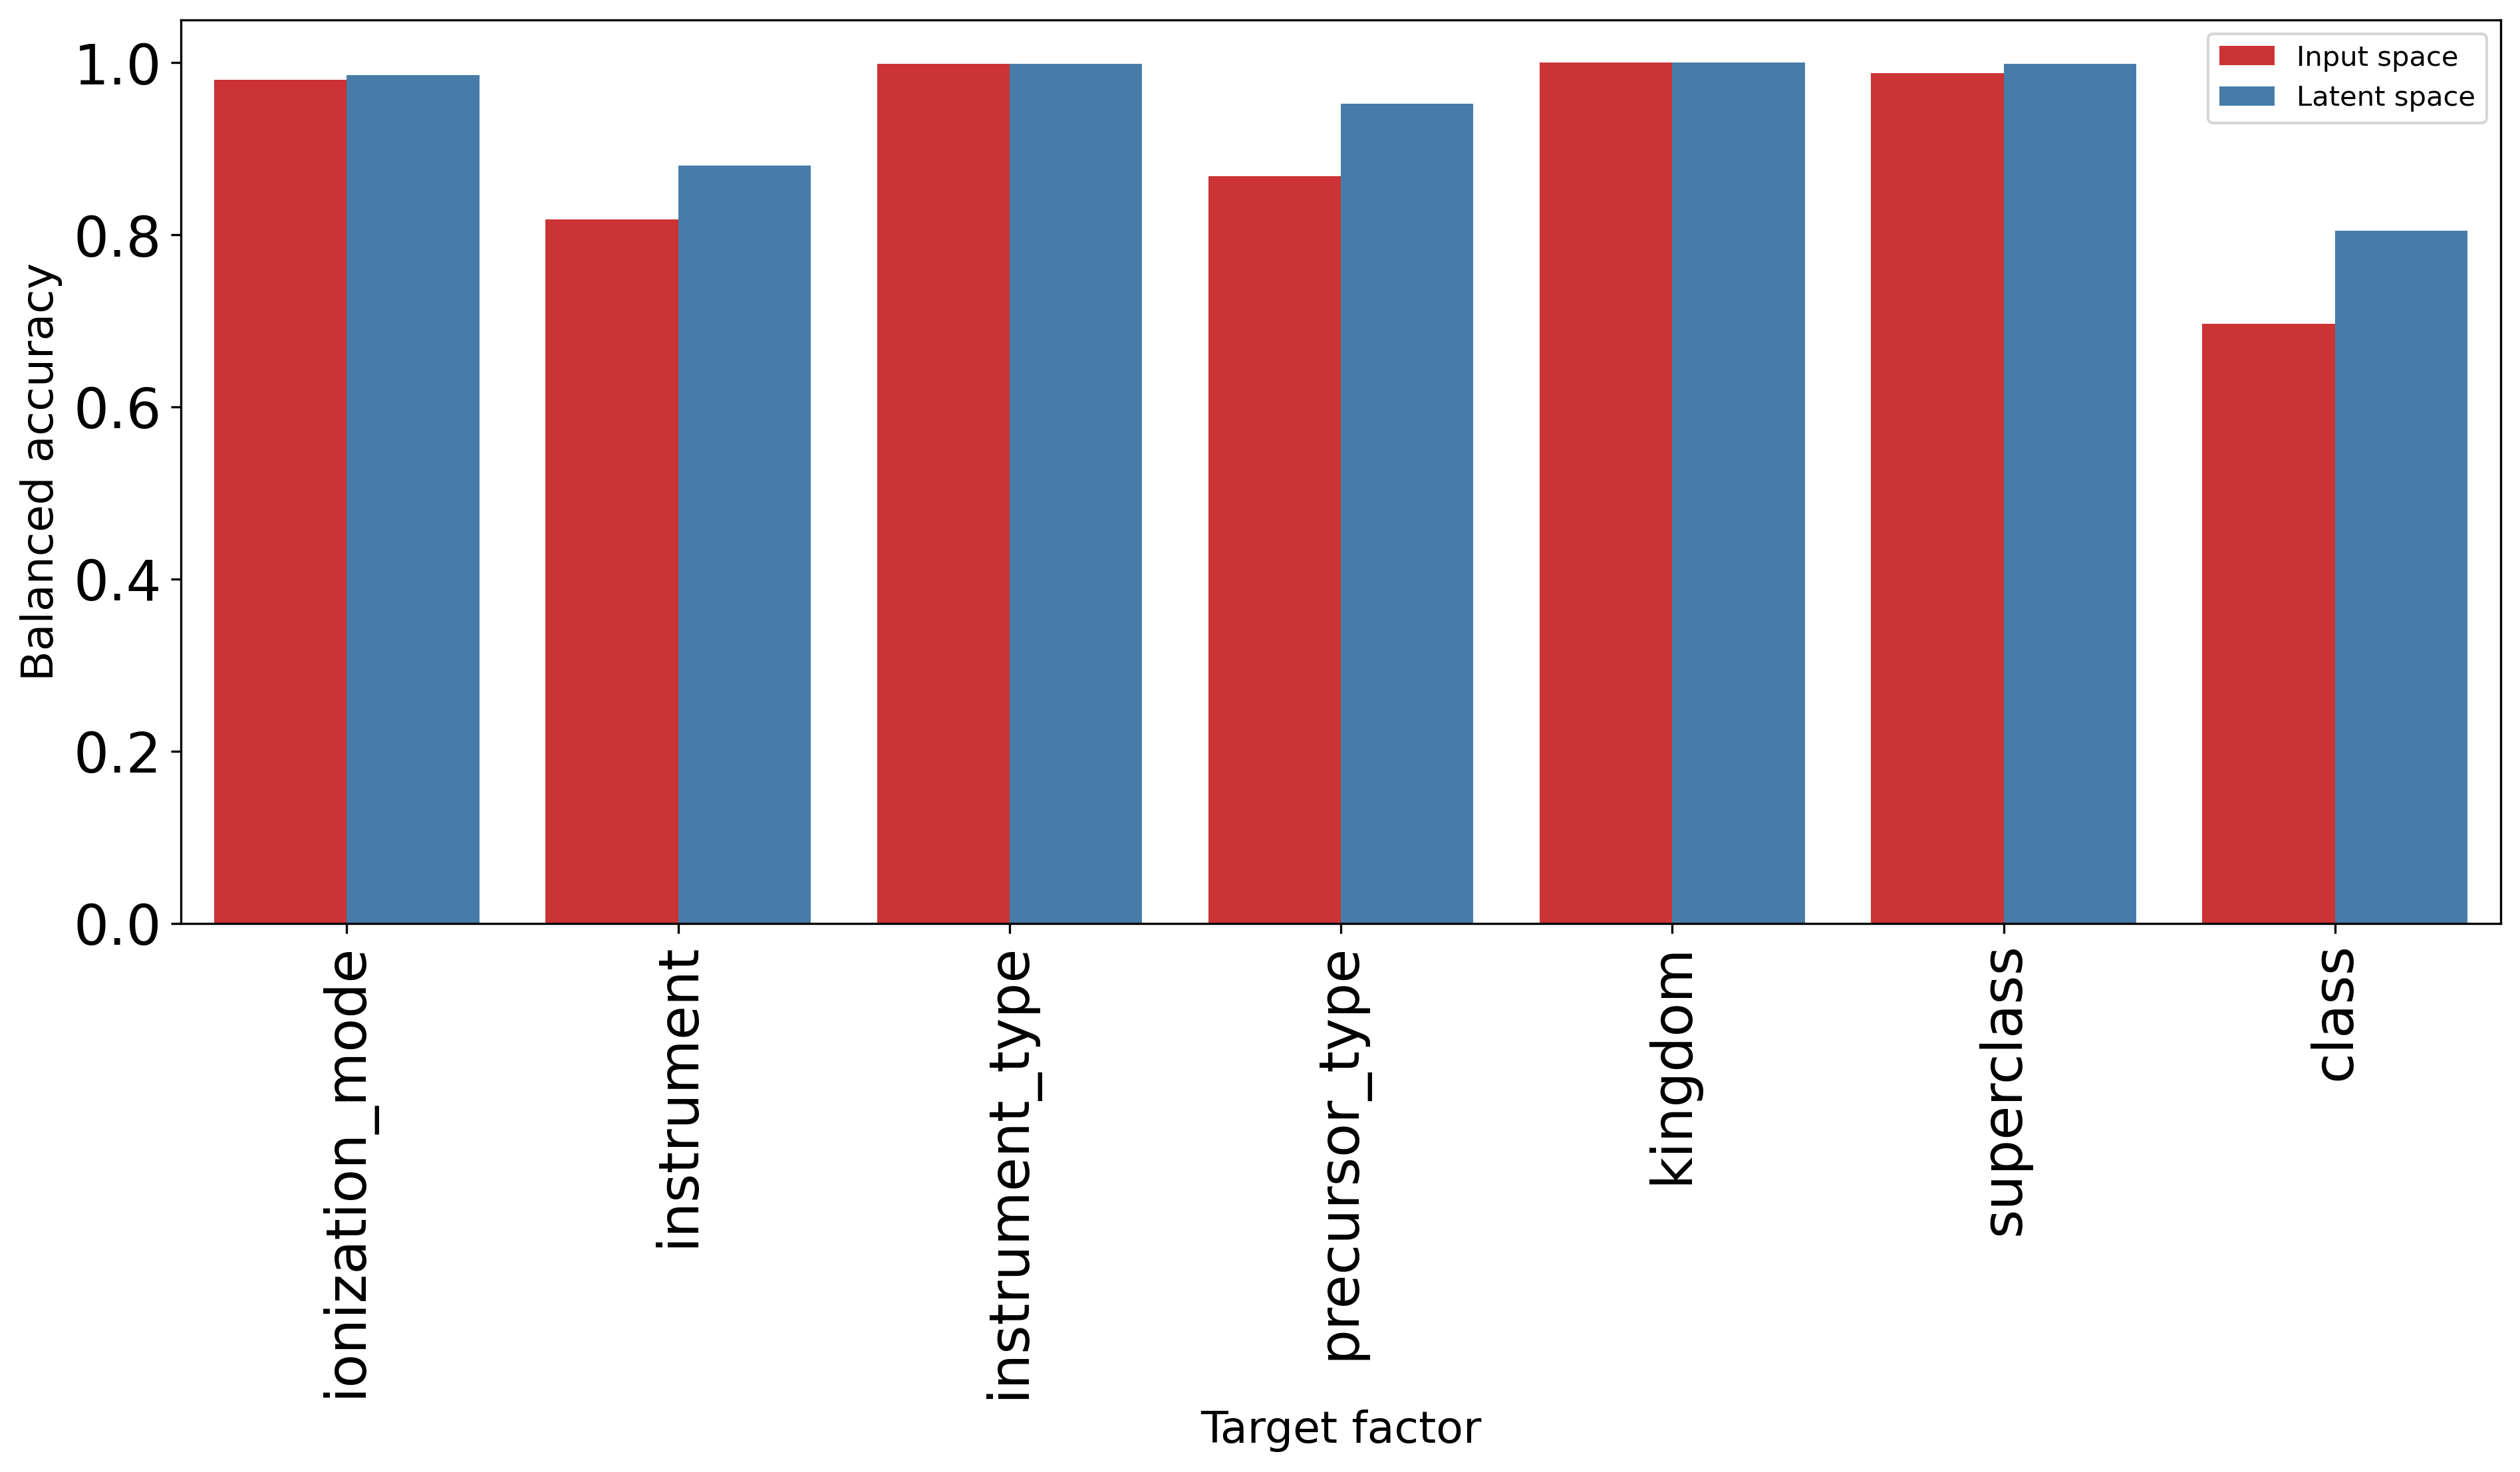

In [82]:
fig, ax = plt.subplots(figsize=(15, 6), dpi=300)
sns.barplot(data=df[(df['name'].isin(['clf', 'betavae_clf'])) & (df['dataset'] == 'MoNA')], x="target_column", y='acc',
    hue="Type", ax=ax, palette='Set1') #, kind="bar", ci="sd", capsize=.05, height=10, aspect=1.5, palette='Set1')
plt.legend(loc='upper right')
plt.ylabel('Balanced accuracy', font={'size': 16})
plt.xlabel('Target factor', font={'size': 16})
plt.yticks(font={'size': 20})
plt.xticks(rotation=90, font={'size': 20})
fig.savefig('../.img/clf-betaclf-mona.svg')

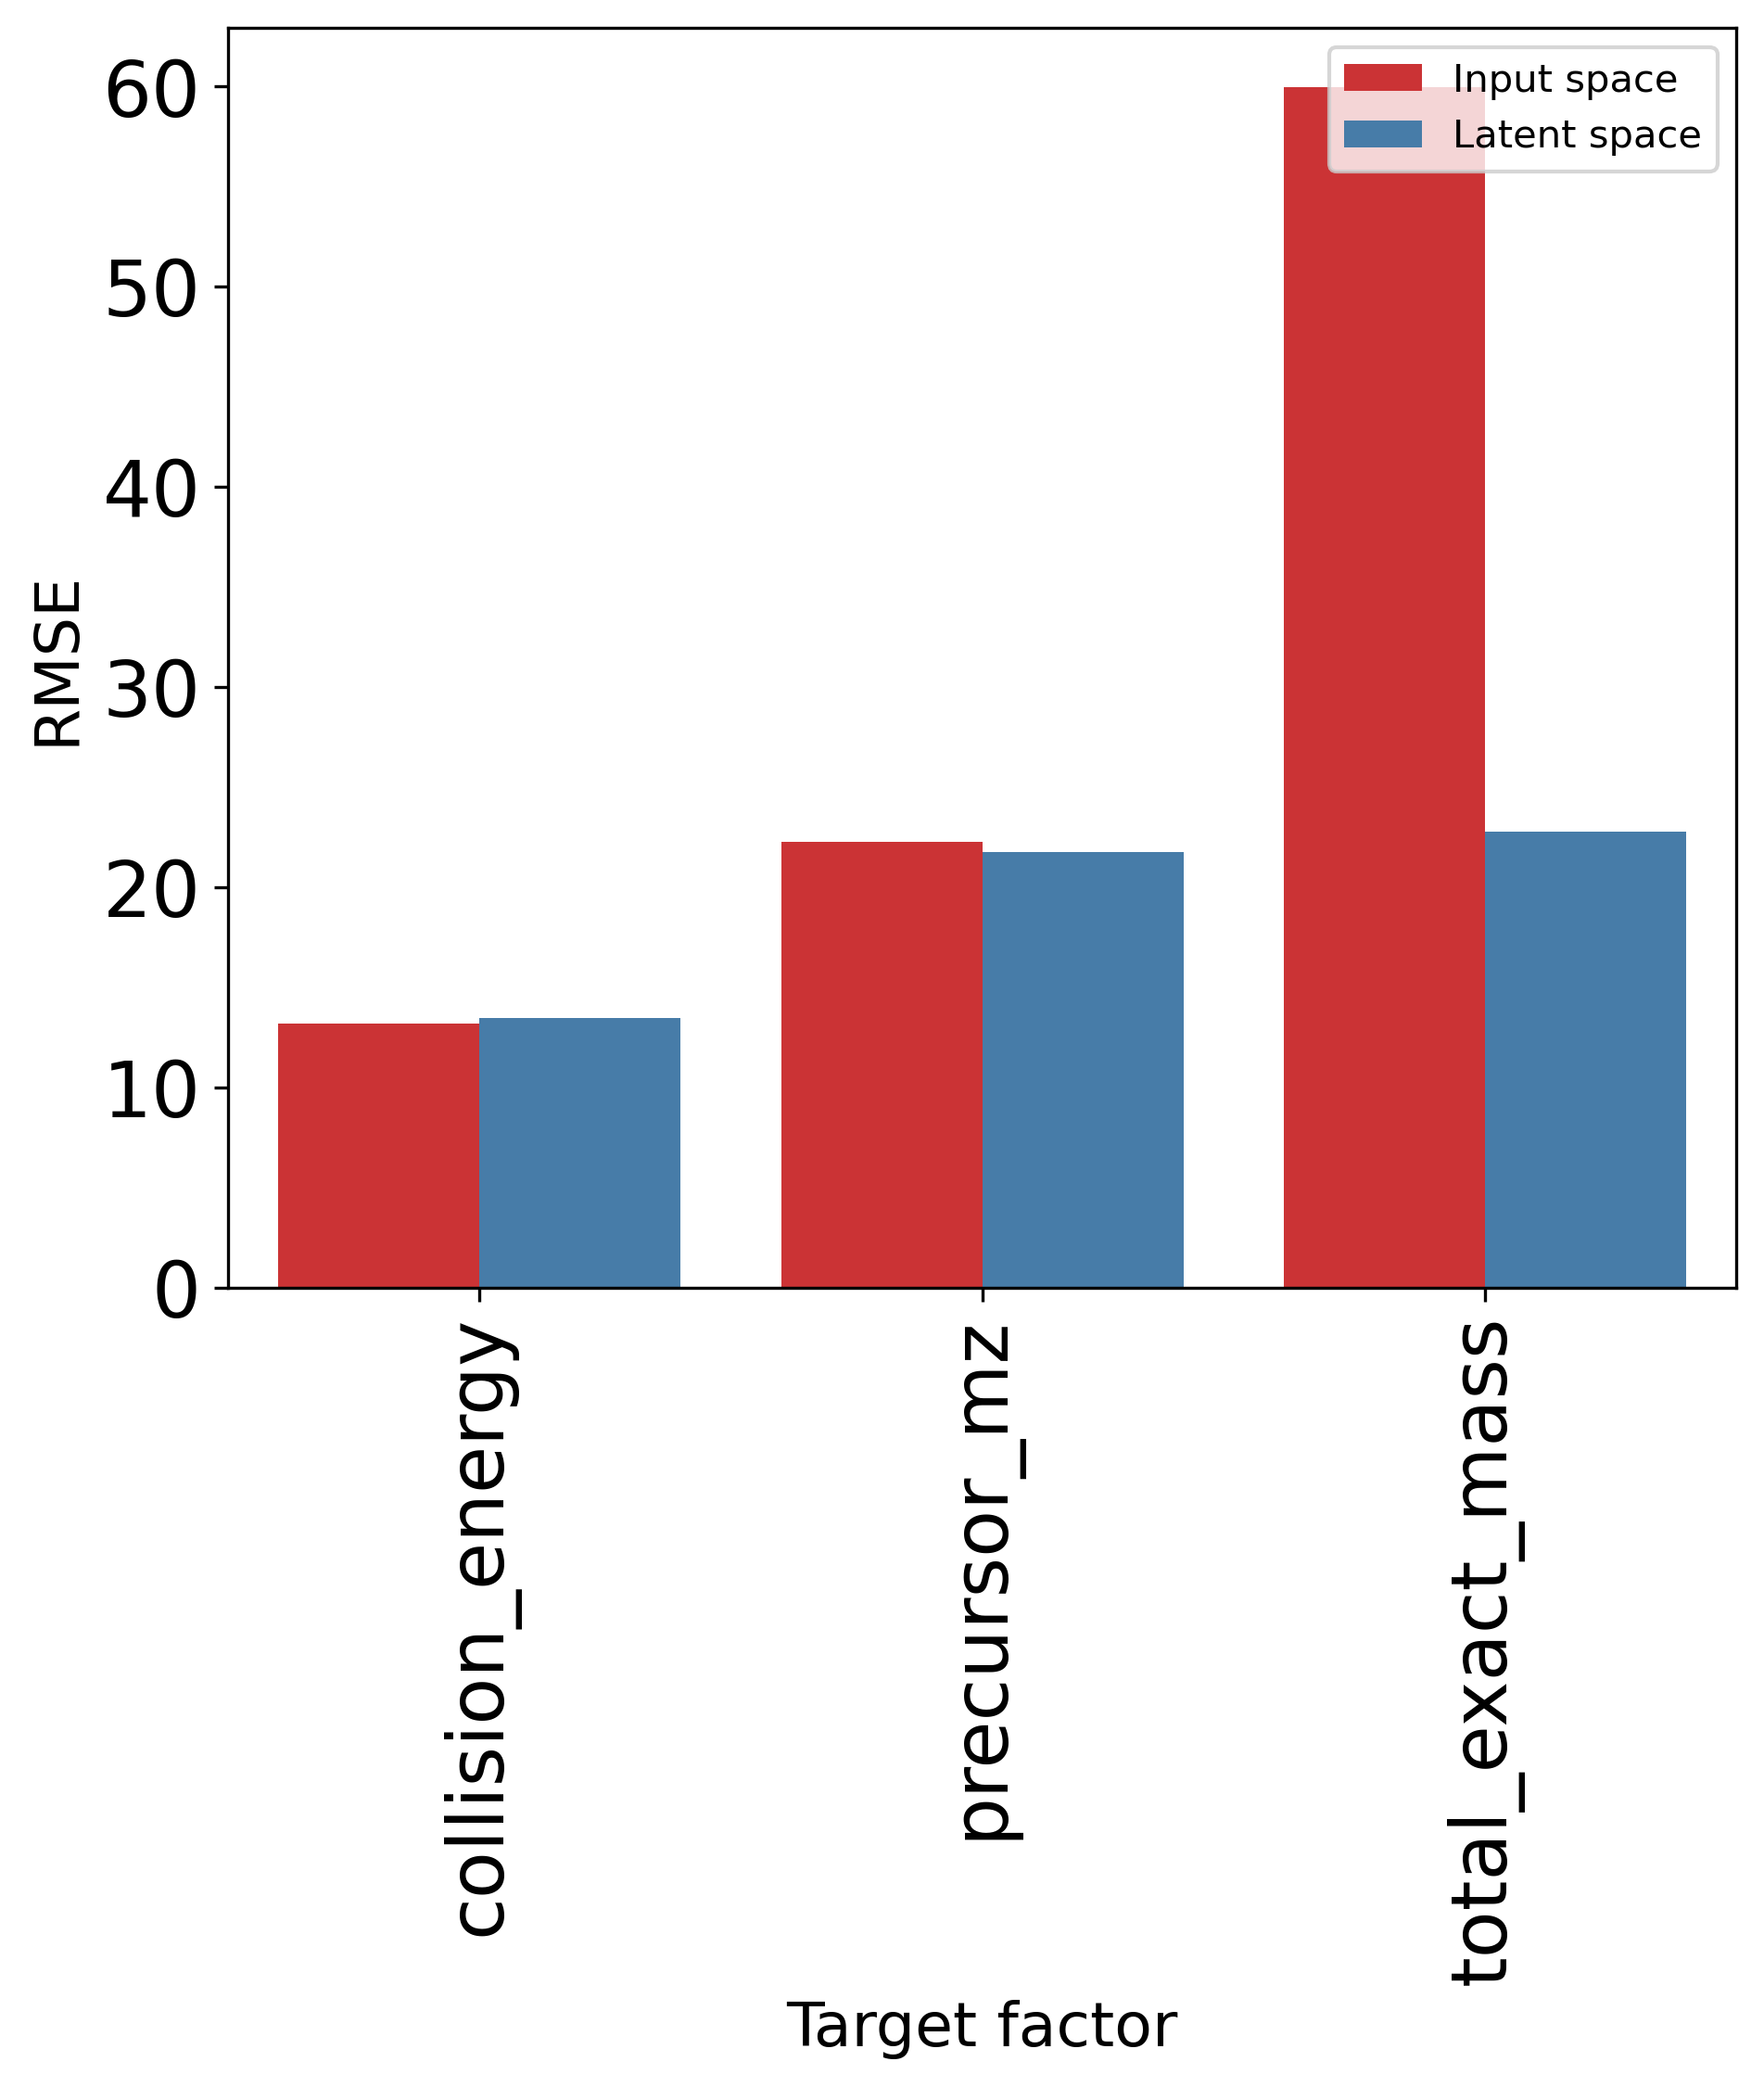

In [83]:
fig, ax = plt.subplots(figsize=(7, 6), dpi=300)
sns.barplot(data=df[(df['name'].isin(['reg', 'betavae_reg'])) & (df['dataset'] == 'MoNA')], x="target_column", y='acc',
    hue="Type", ax=ax, palette='Set1')
plt.legend(loc='upper right')
plt.ylabel('RMSE', font={'size': 16})
plt.xlabel('Target factor', font={'size': 16})
plt.yticks(font={'size': 20})
plt.xticks(rotation=90, font={'size': 20})
fig.savefig('../.img/reg-betareg-mona.svg')

## Feature importance

Permutation feature importance might vary depending on preprocessing parameters.

In [84]:
target_columns = df['target_column'].unique().tolist()
target_columns

['ionization_mode',
 'instrument',
 'instrument_type',
 'precursor_type',
 'kingdom',
 'superclass',
 'class',
 'collision_energy',
 'precursor_mz',
 'total_exact_mass']

In [85]:
def extract_pfi(df, target_column):
    import ast
    dfpi = df[df['target_column'].isin([target_column])]
    def extract_pfi_(row):
        fi_dict = ast.literal_eval(row['feature_importance'])
        for k, v in fi_dict.items():
            row['pfi_' + k] = v
        return row
    return dfpi.apply(extract_pfi_, axis=1)

def plot_pfi(df, target_column, hue=None):
    dfpi = extract_pfi(df, target_column)
    pfi_cols = list(filter(lambda x: x.startswith('pfi_'), list(dfpi.columns)))
    oth_cols = list(filter(lambda x: not x.startswith('pfi_'), list(dfpi.columns)))
    dfpi = dfpi.melt(id_vars=oth_cols, value_vars=pfi_cols, var_name='PFI_column', value_name='PFI')
    result = dfpi.groupby(["PFI_column"])['PFI'].aggregate(np.mean).reset_index().sort_values('PFI', ascending=False)
    # ax = sns.catplot(data=dfpi, x="PFI", y="PFI_column", 
        # hue=hue, row='dataset', kind="bar", ci="sd", 
        # capsize=.05, height=10, aspect=1.5, order=result['PFI_column'],
        # palette='Set1', edgecolor=".6")
    sns.barplot(data=dfpi, x="PFI", y="PFI_column", 
        hue=hue, order=result['PFI_column'],
        palette='Set1') #, edgecolor=".6")
    # ax.fig.title("PFI for %s target variable" % target_column)


Merge tables and preprocess feature_importance column. Export clean table to CSV.

### General

ionization_mode


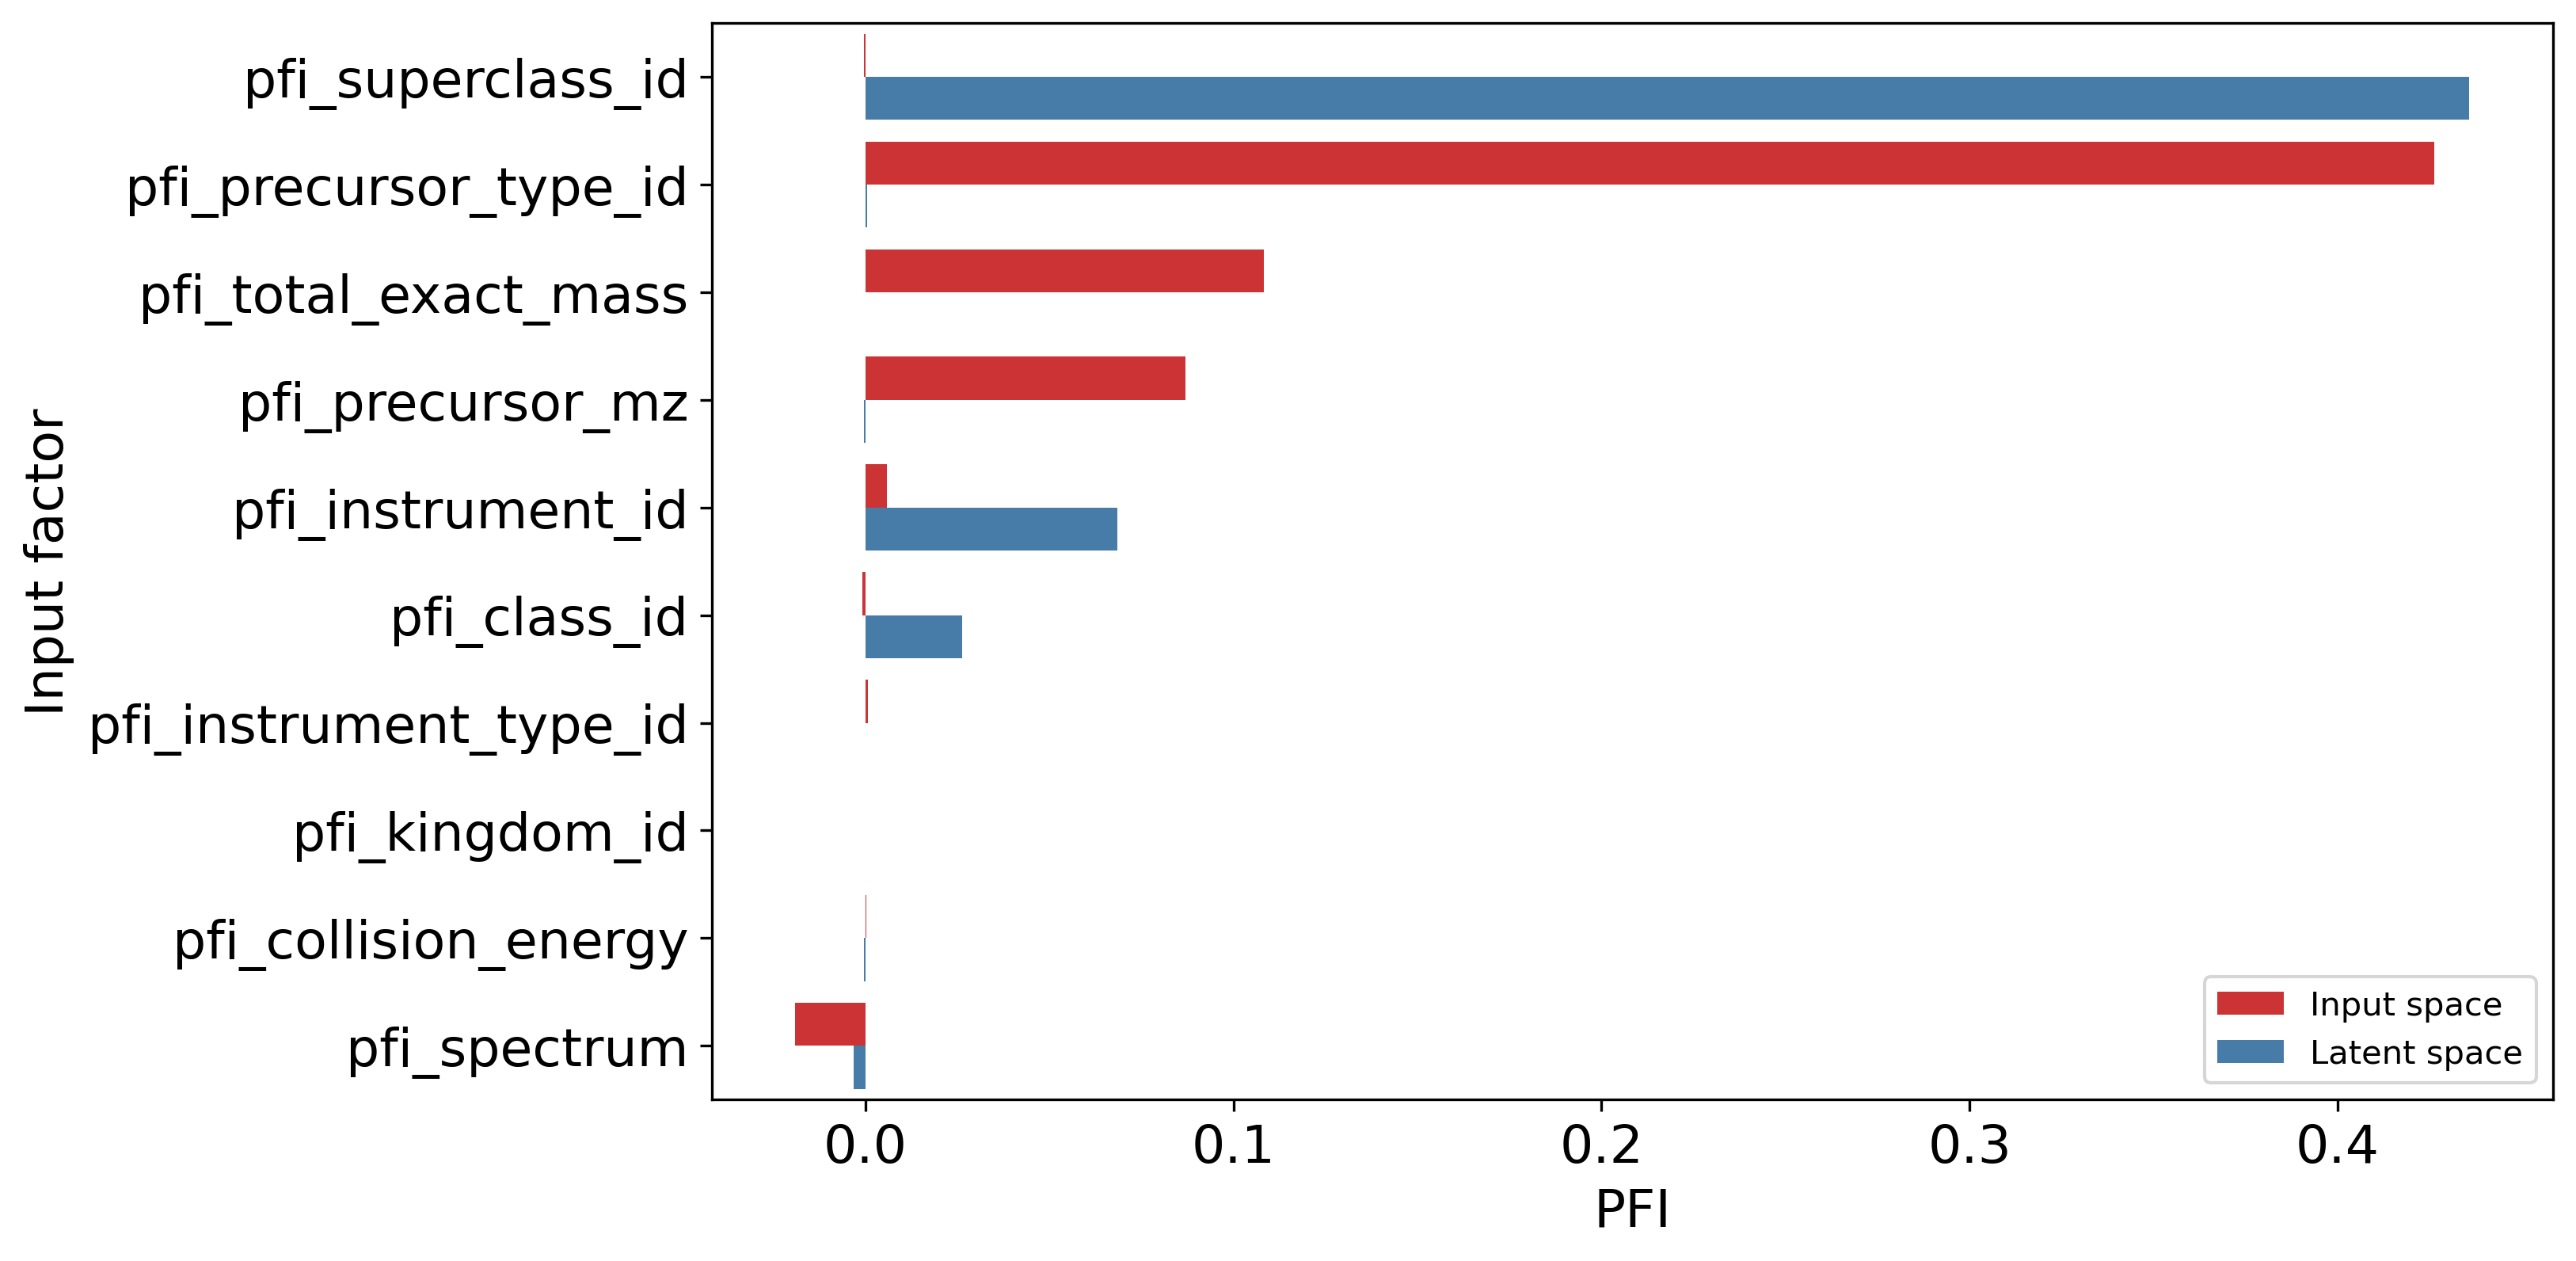

instrument


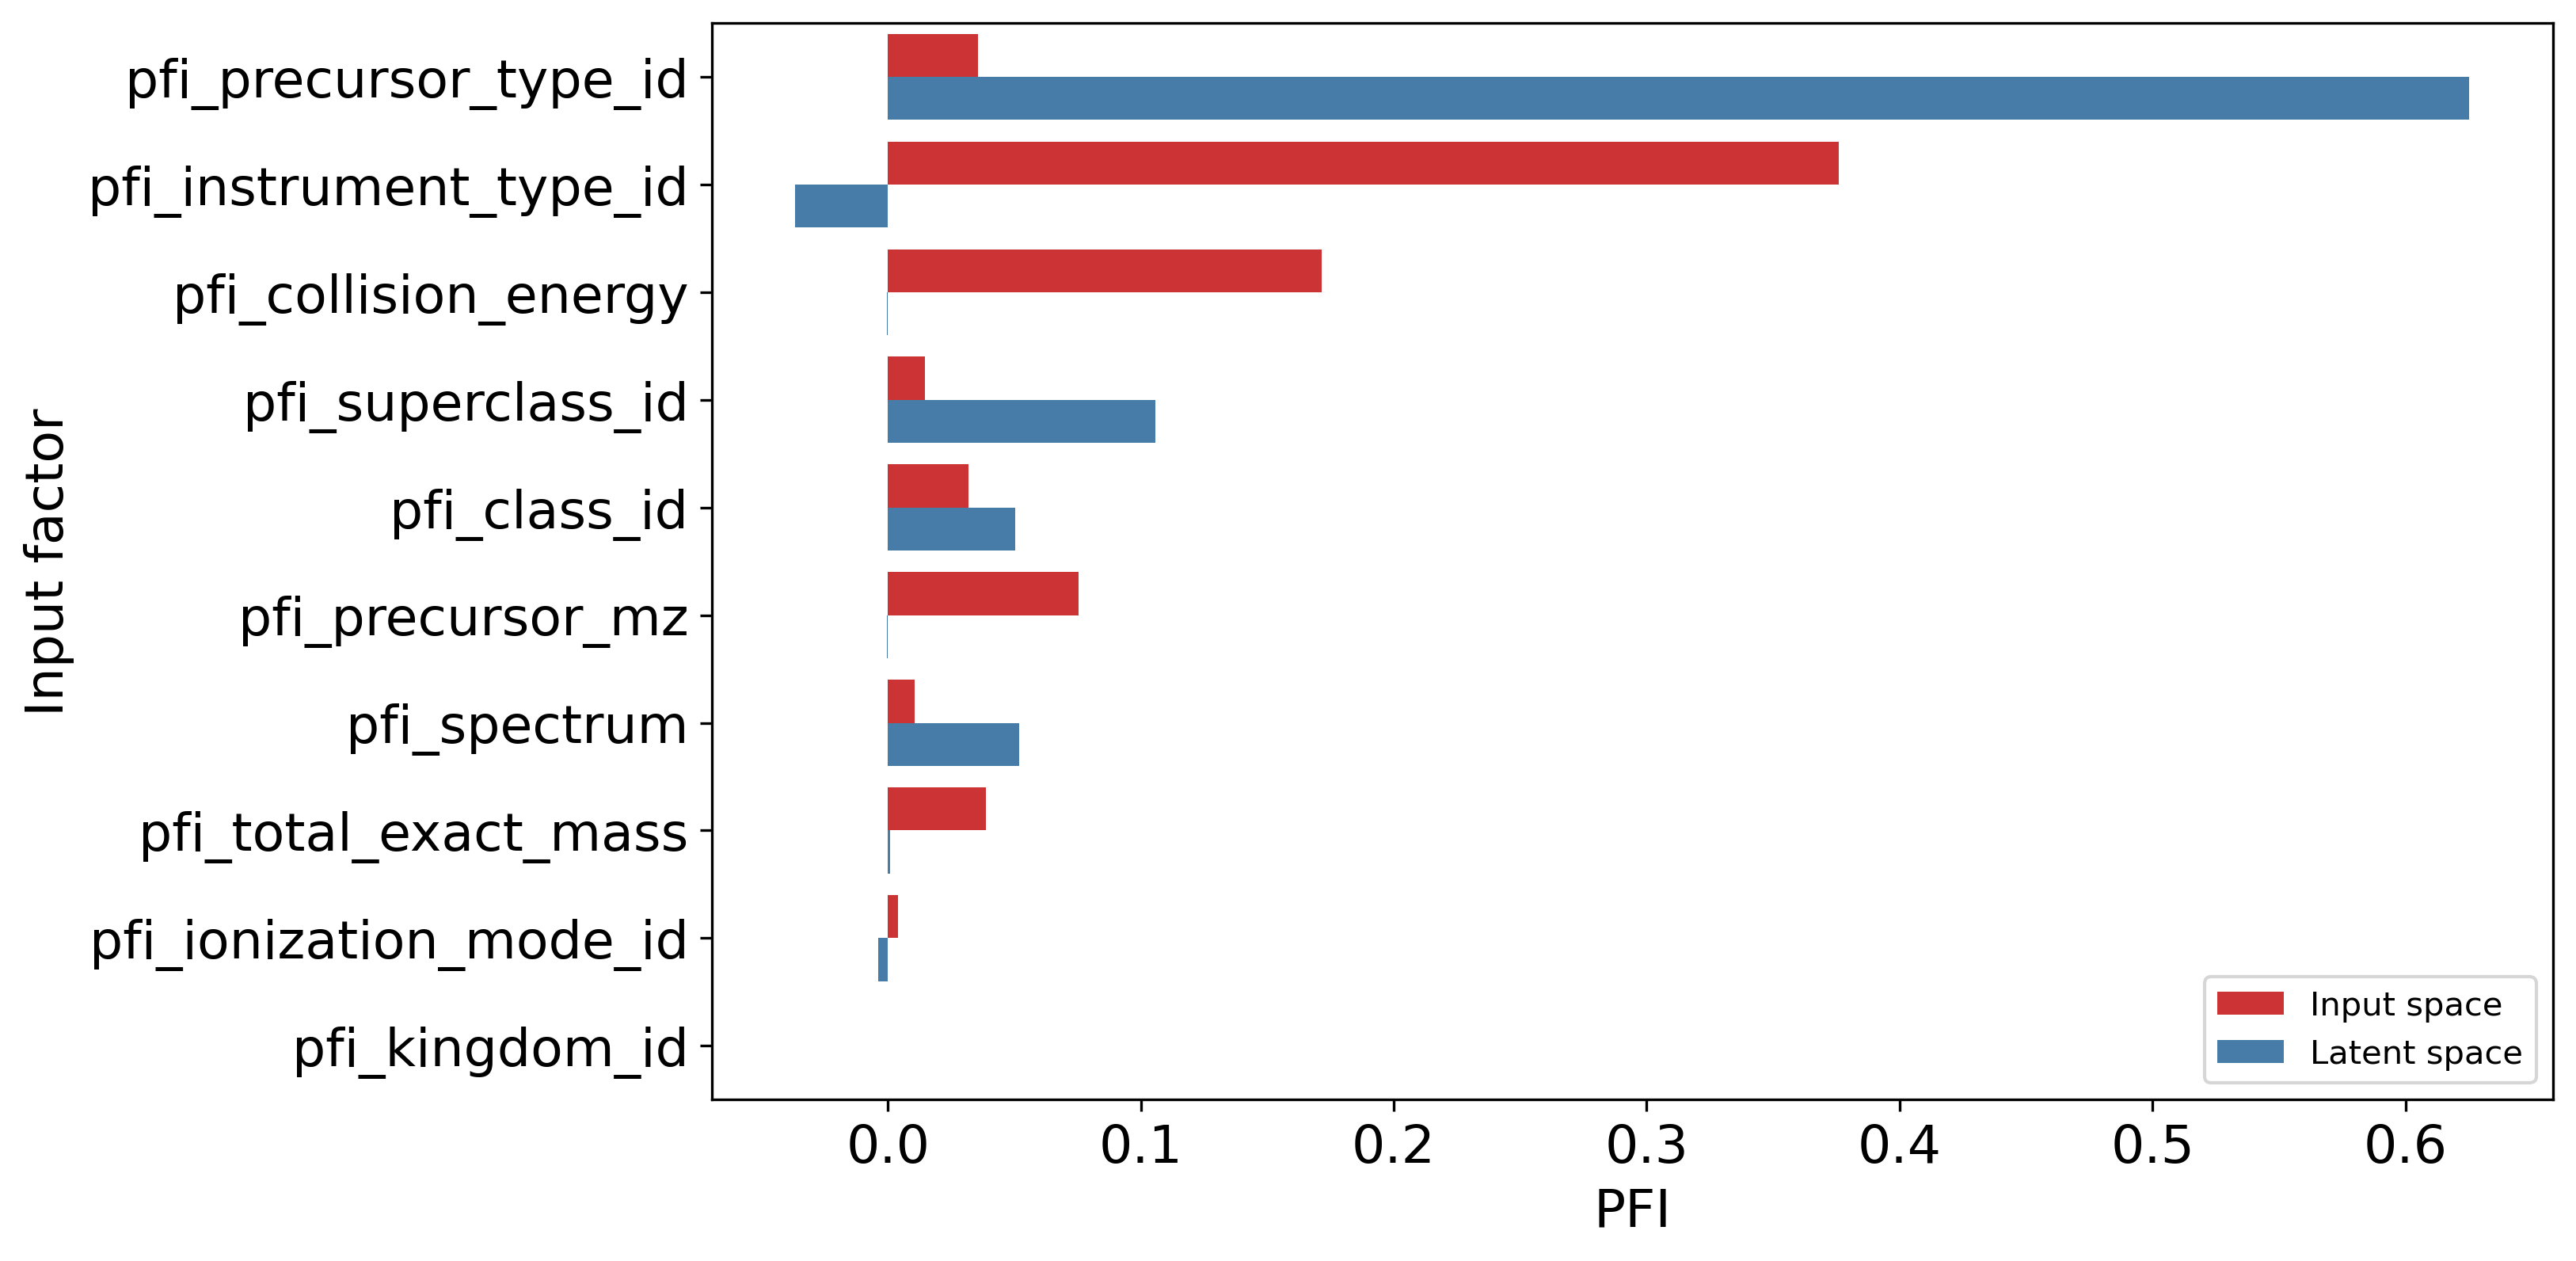

instrument_type


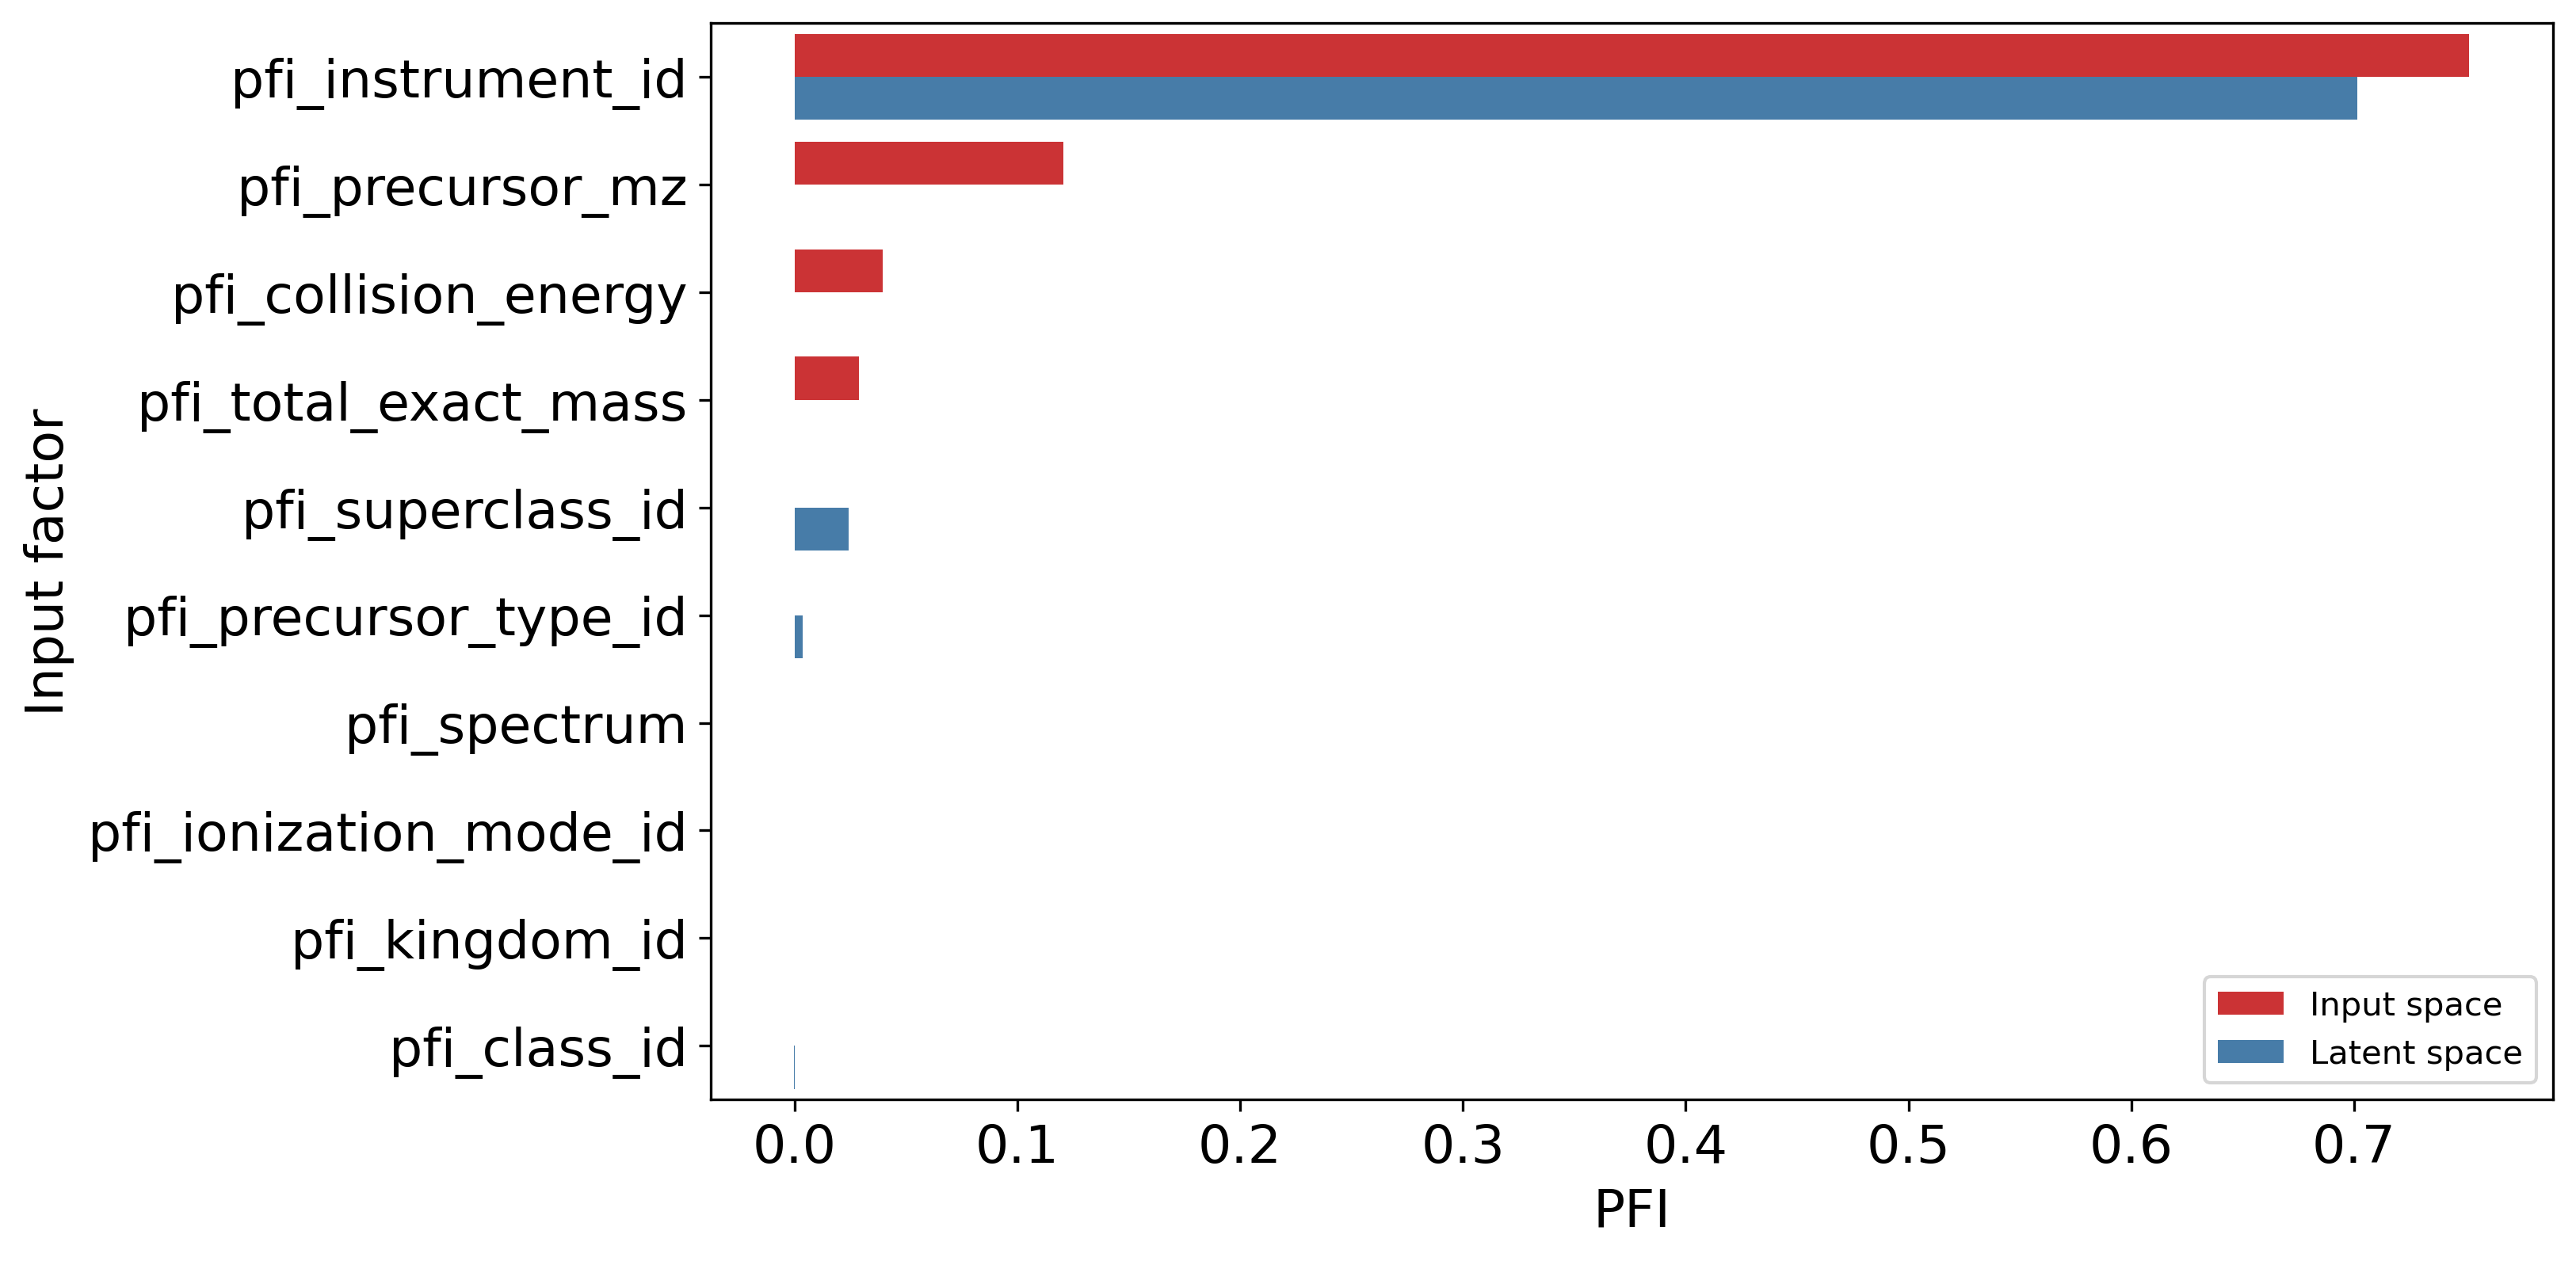

precursor_type


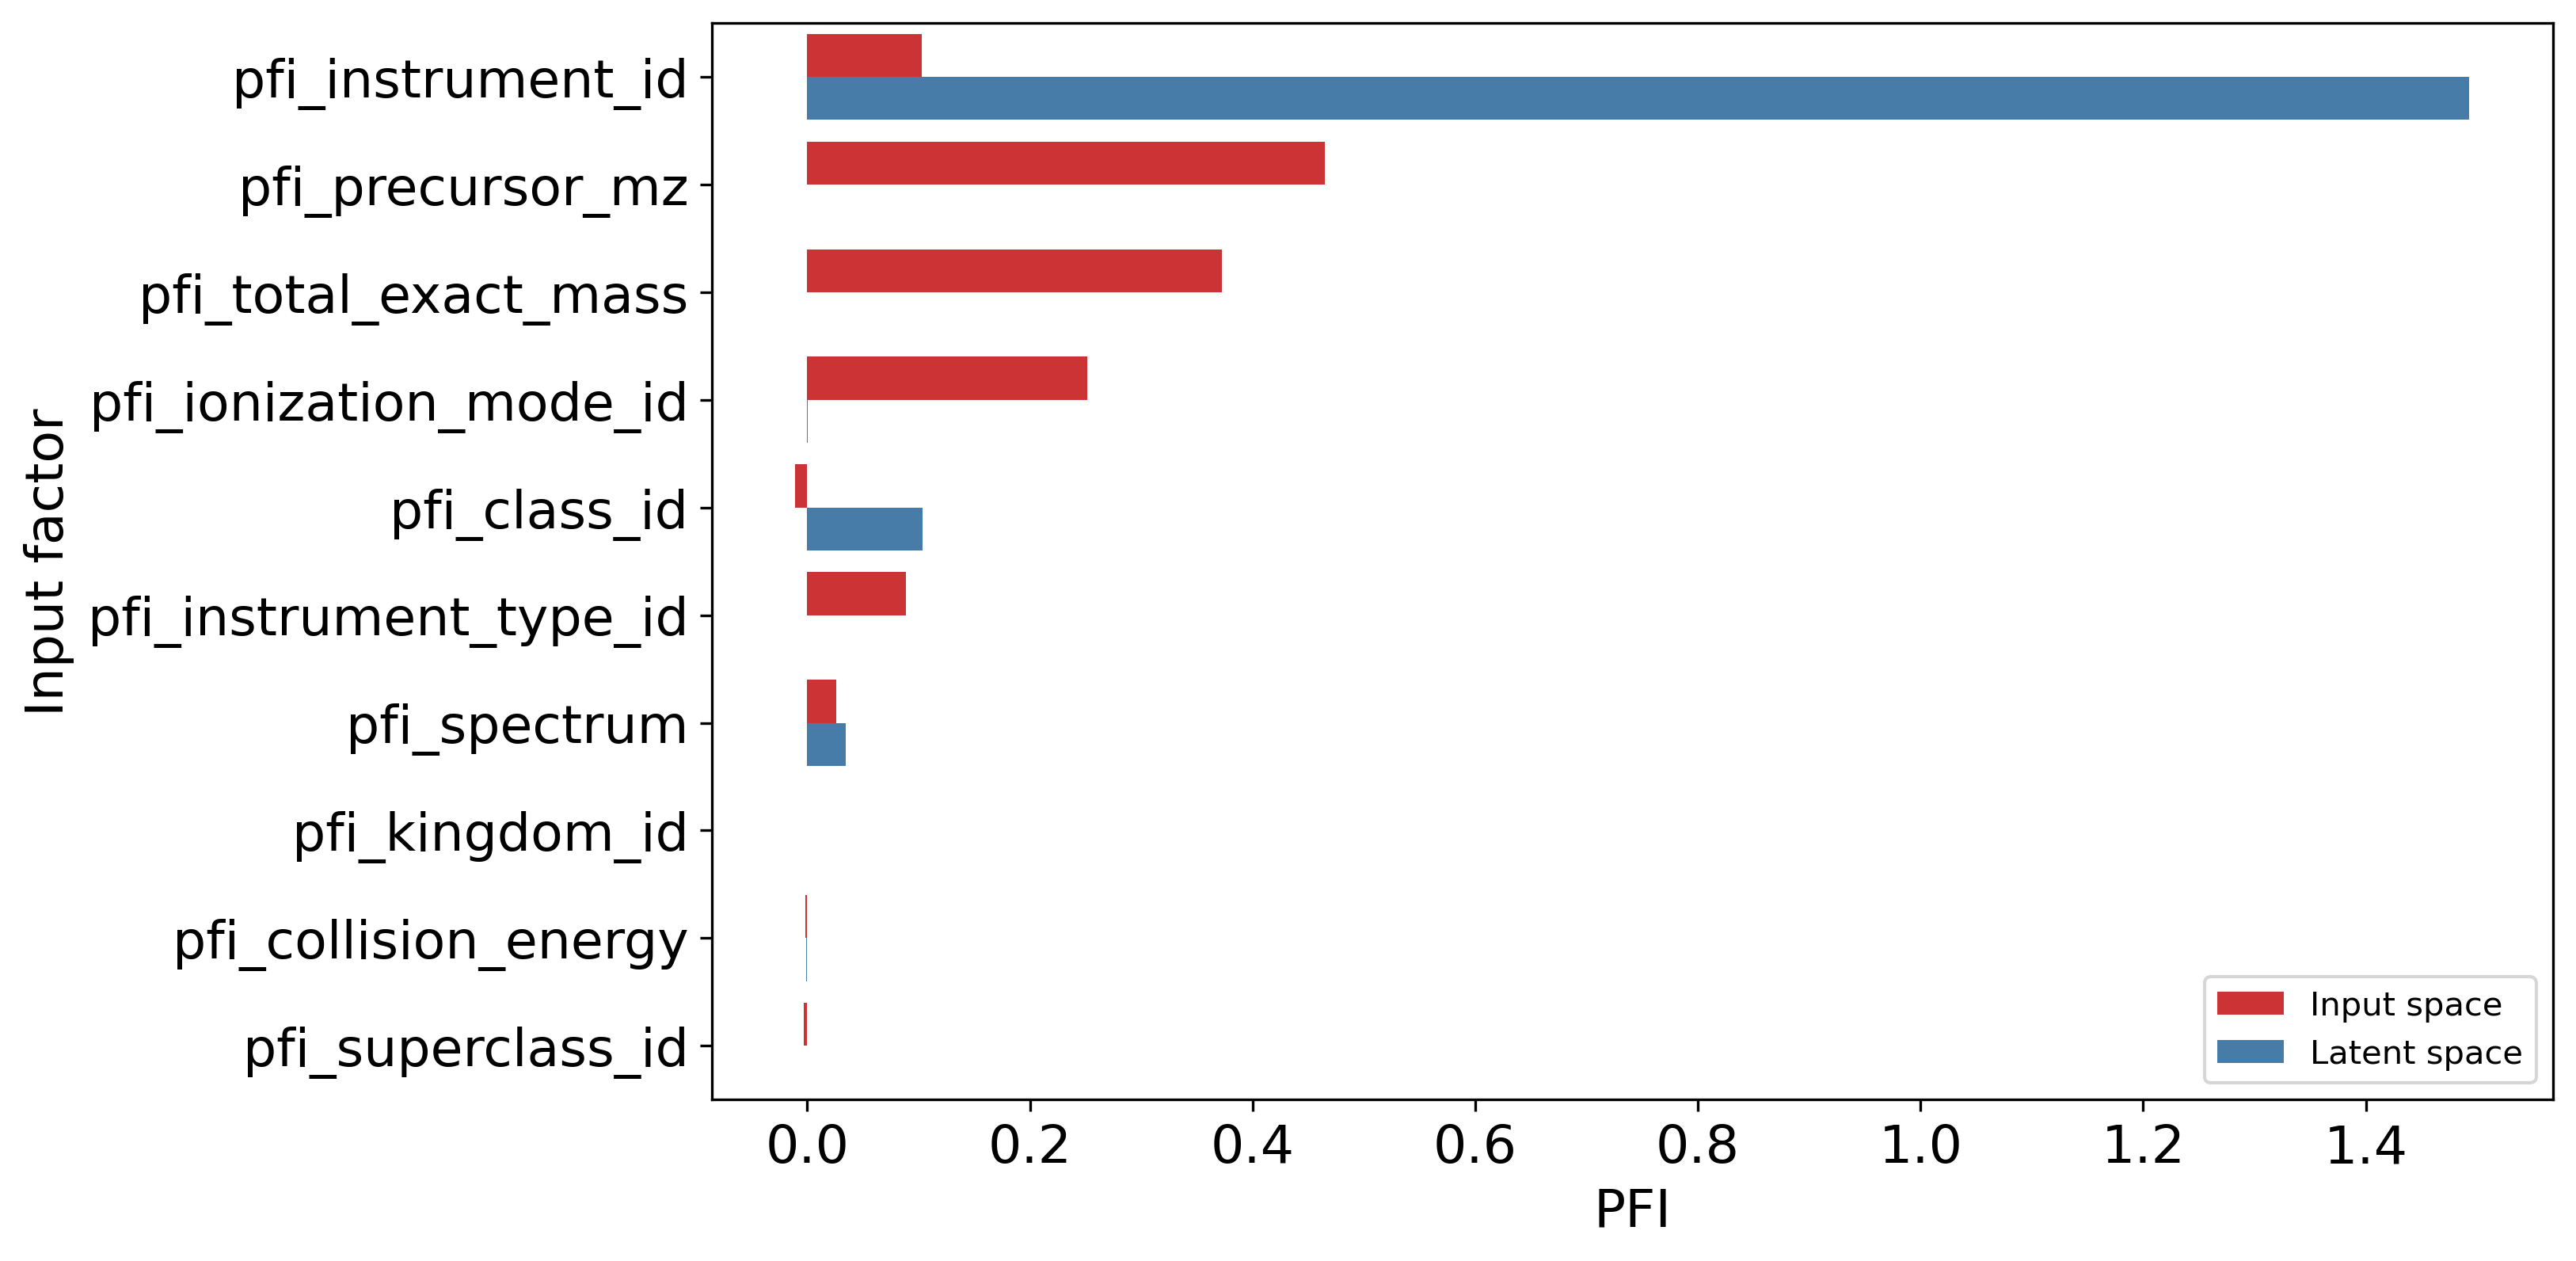

kingdom


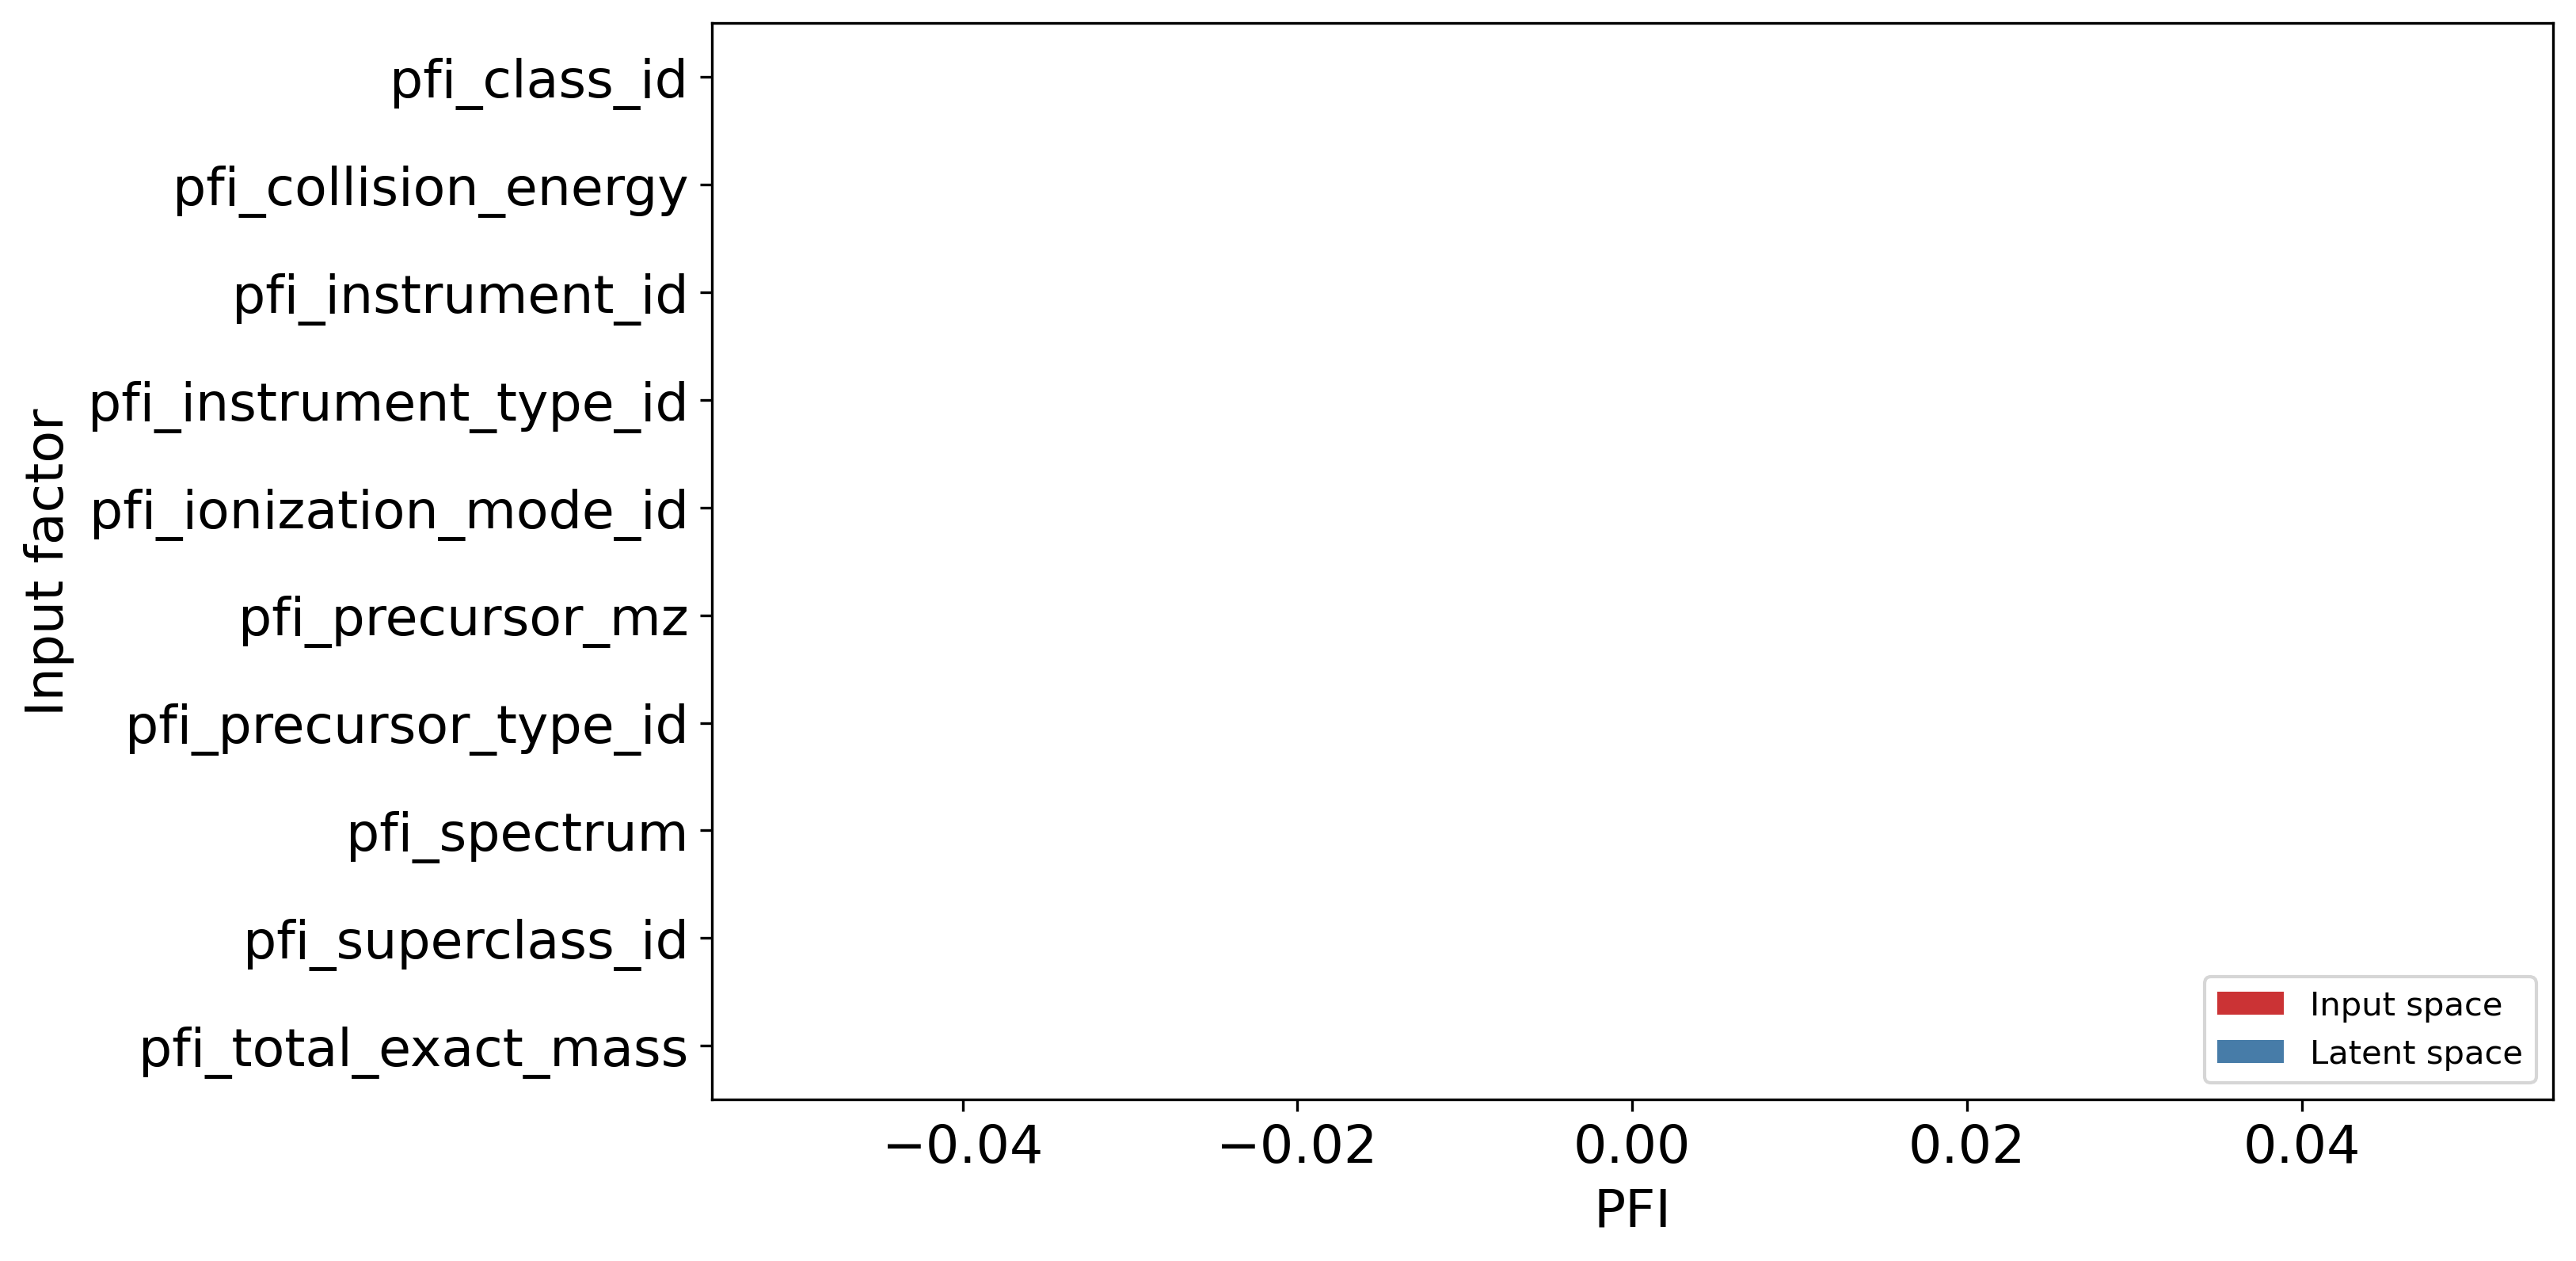

superclass


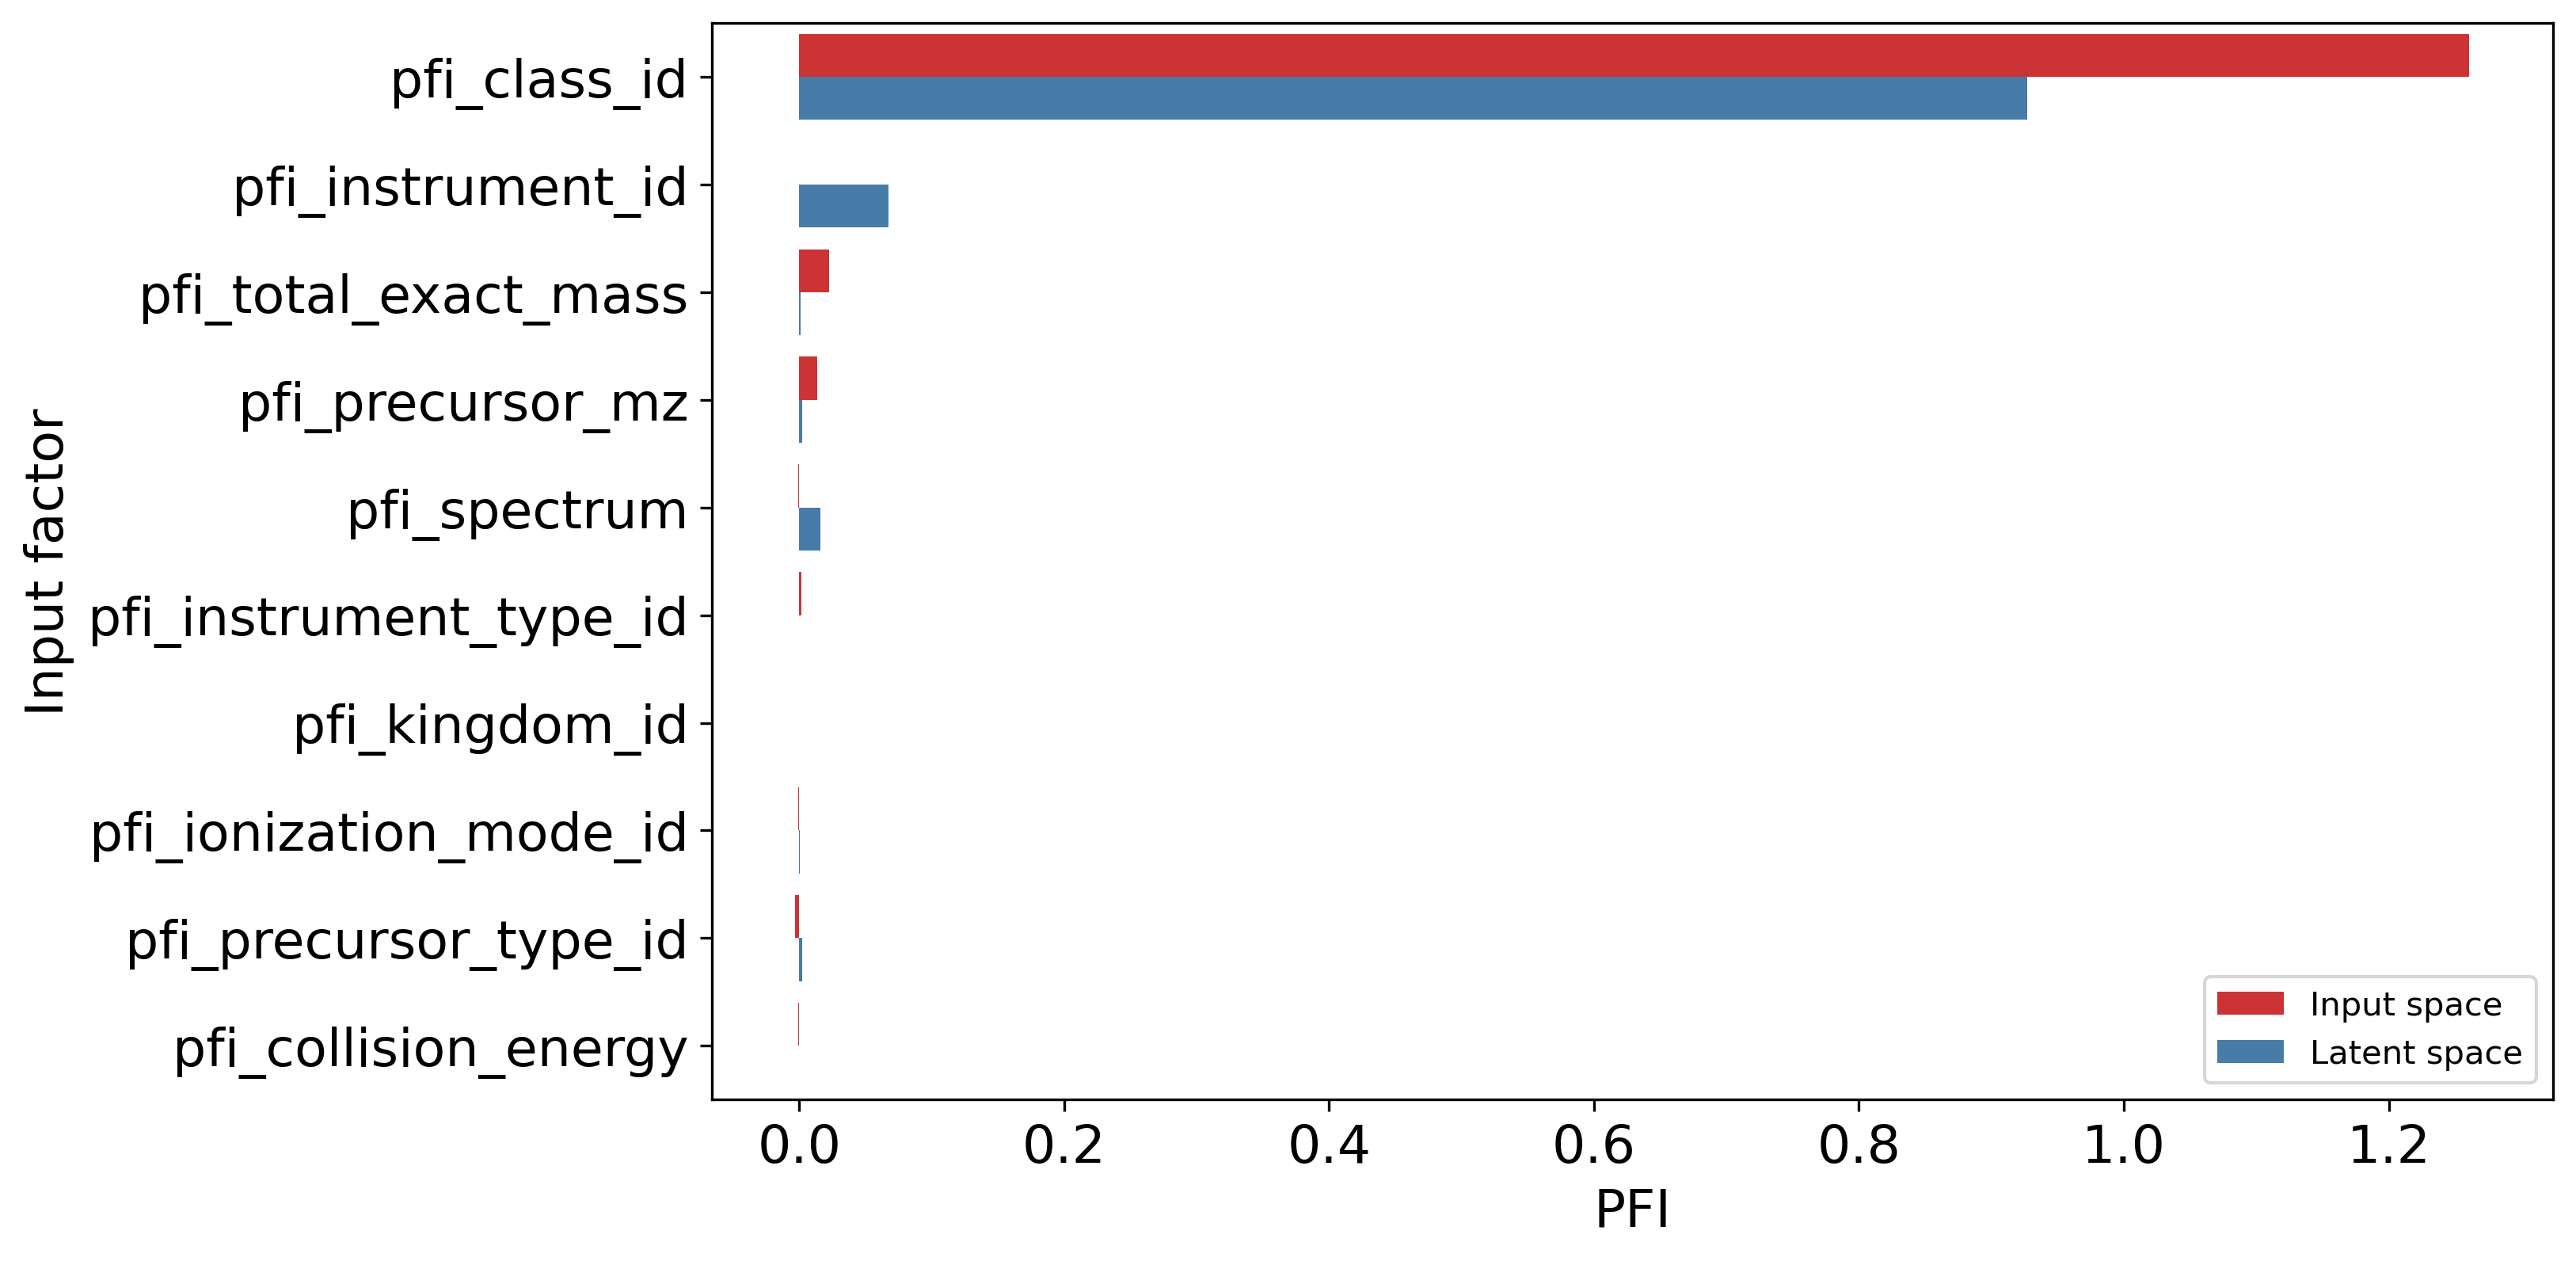

class


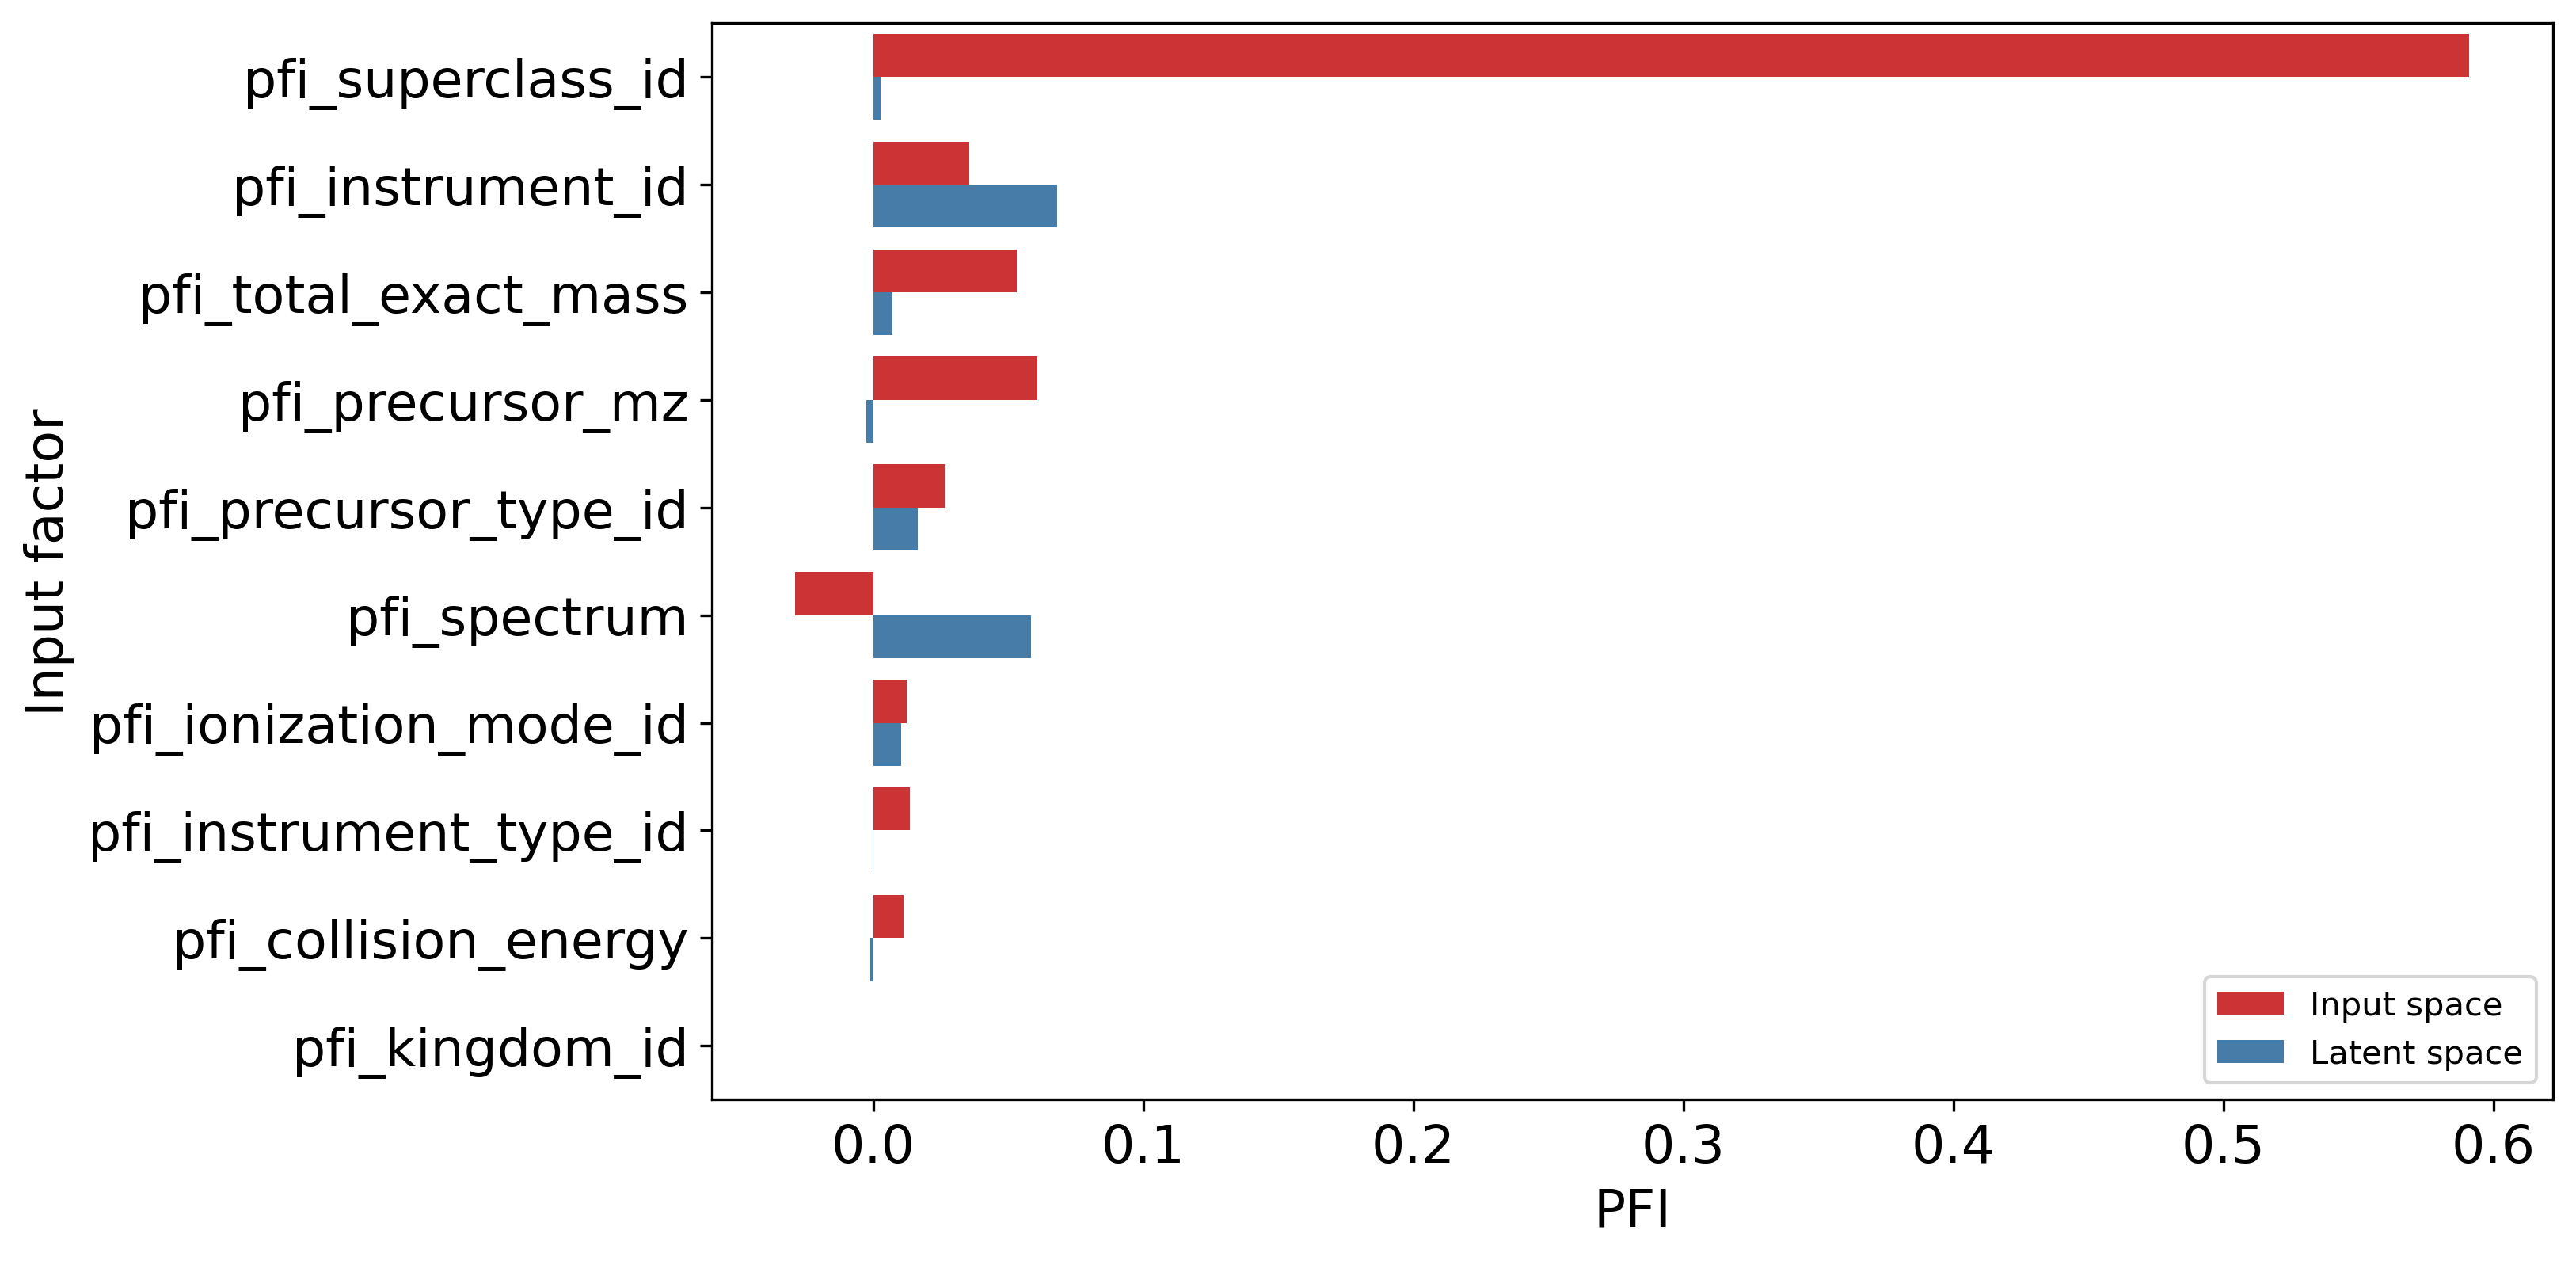

collision_energy


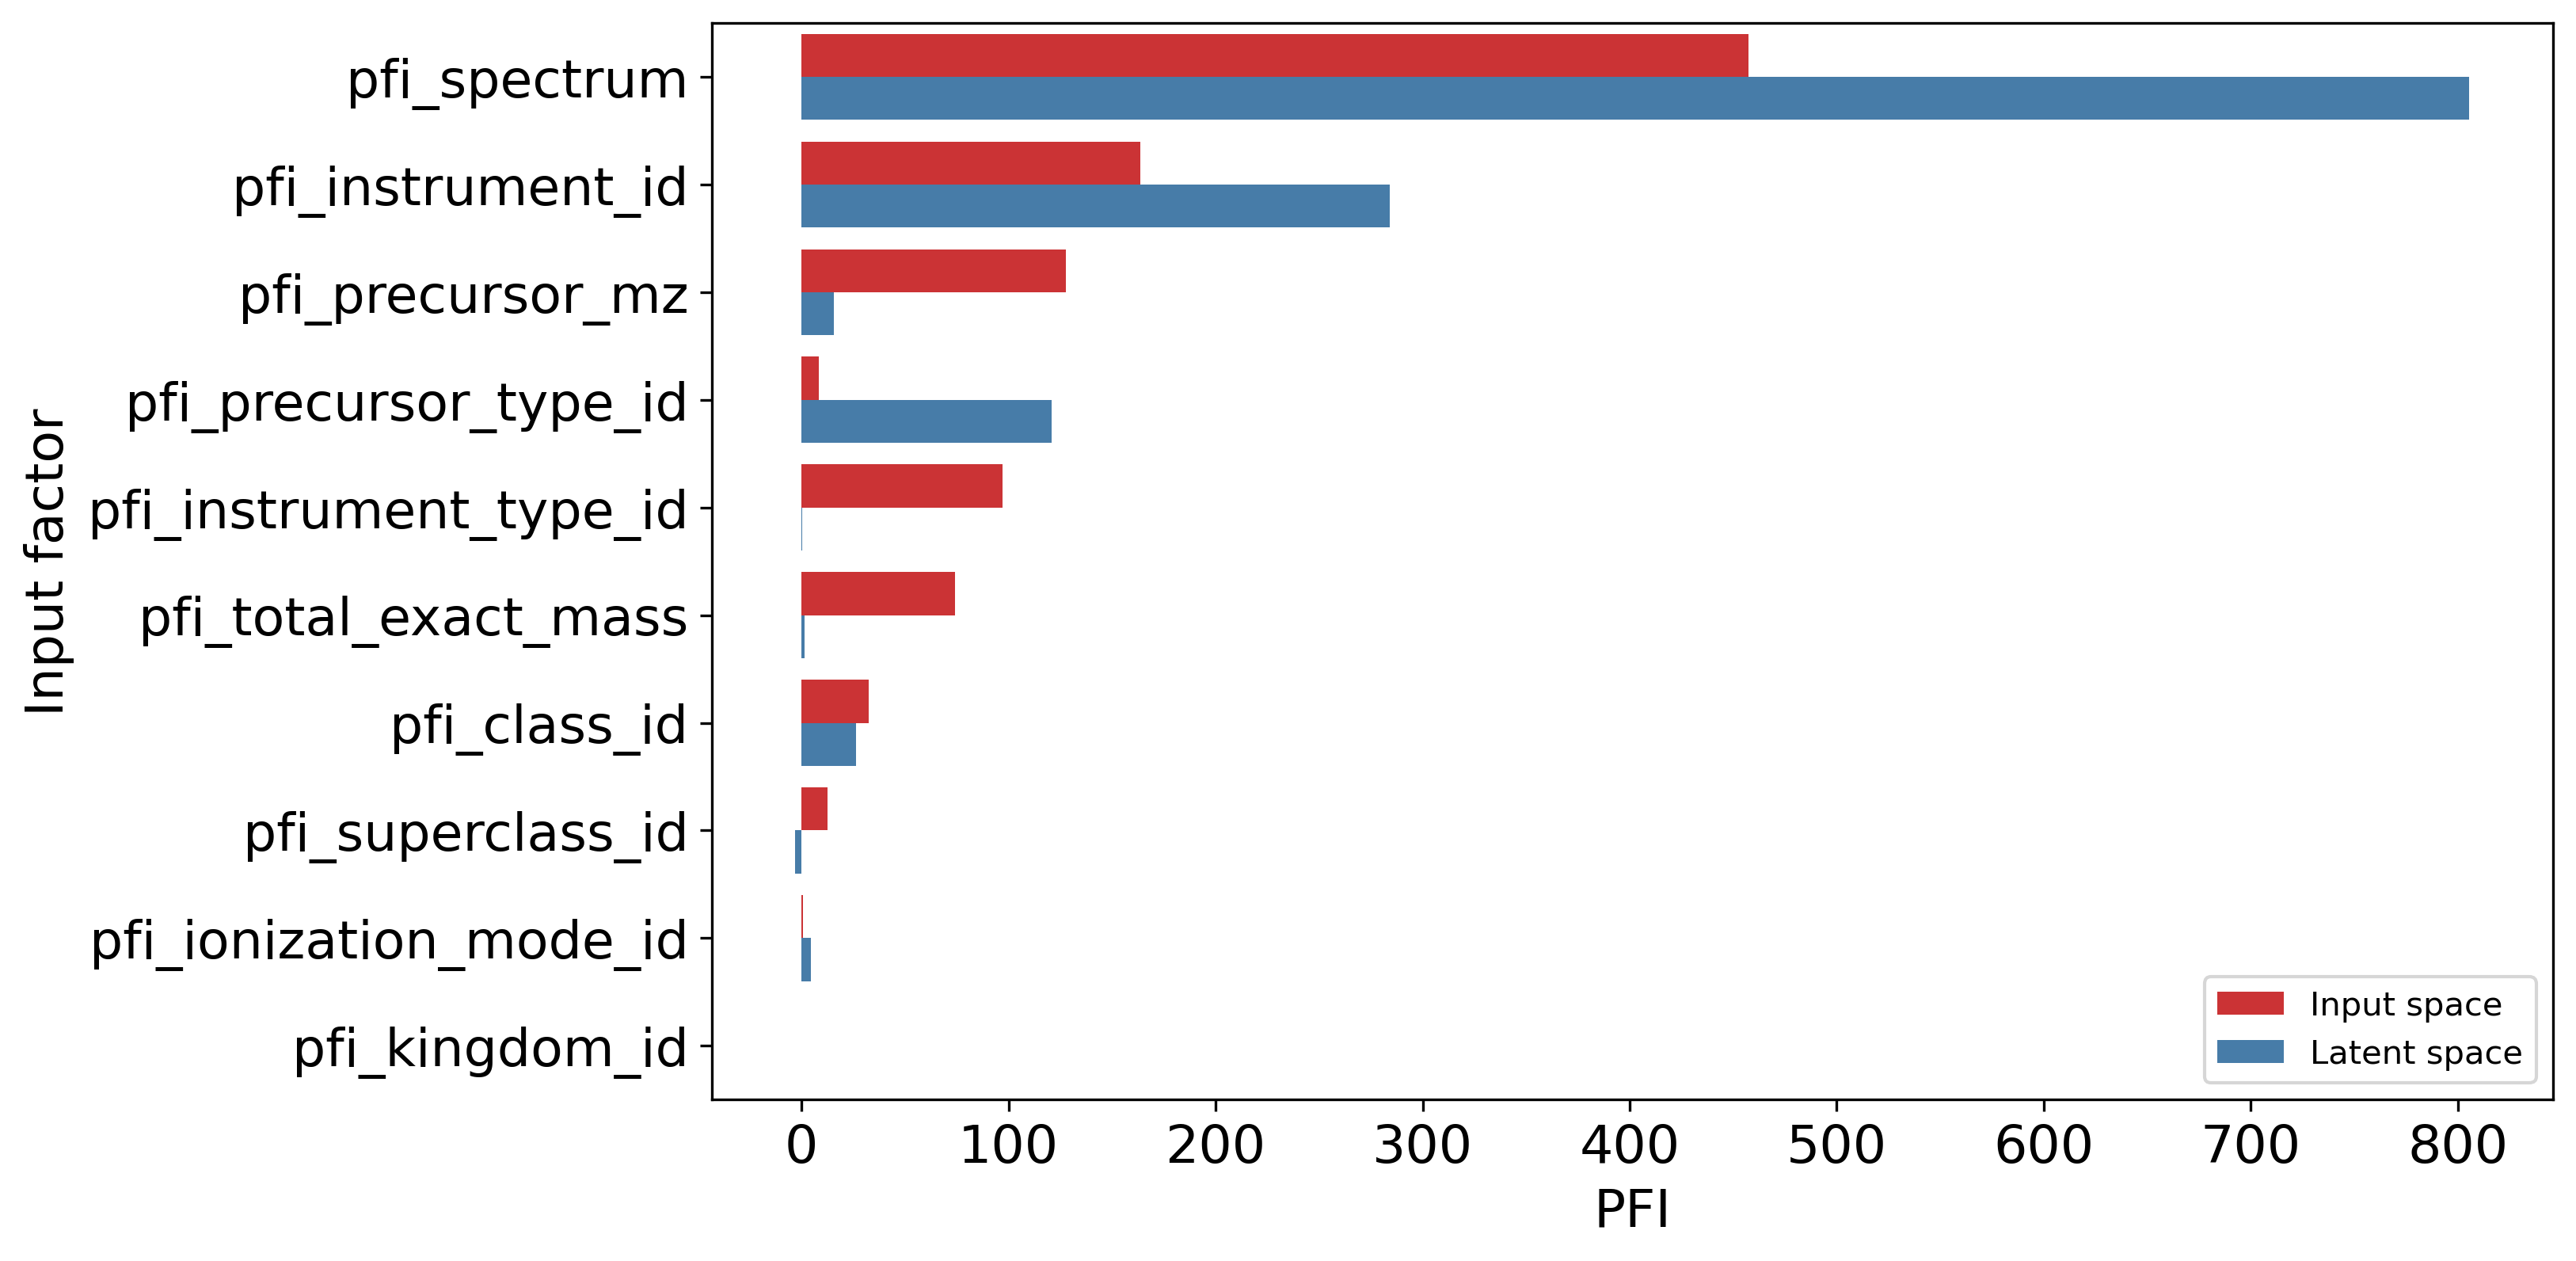

precursor_mz


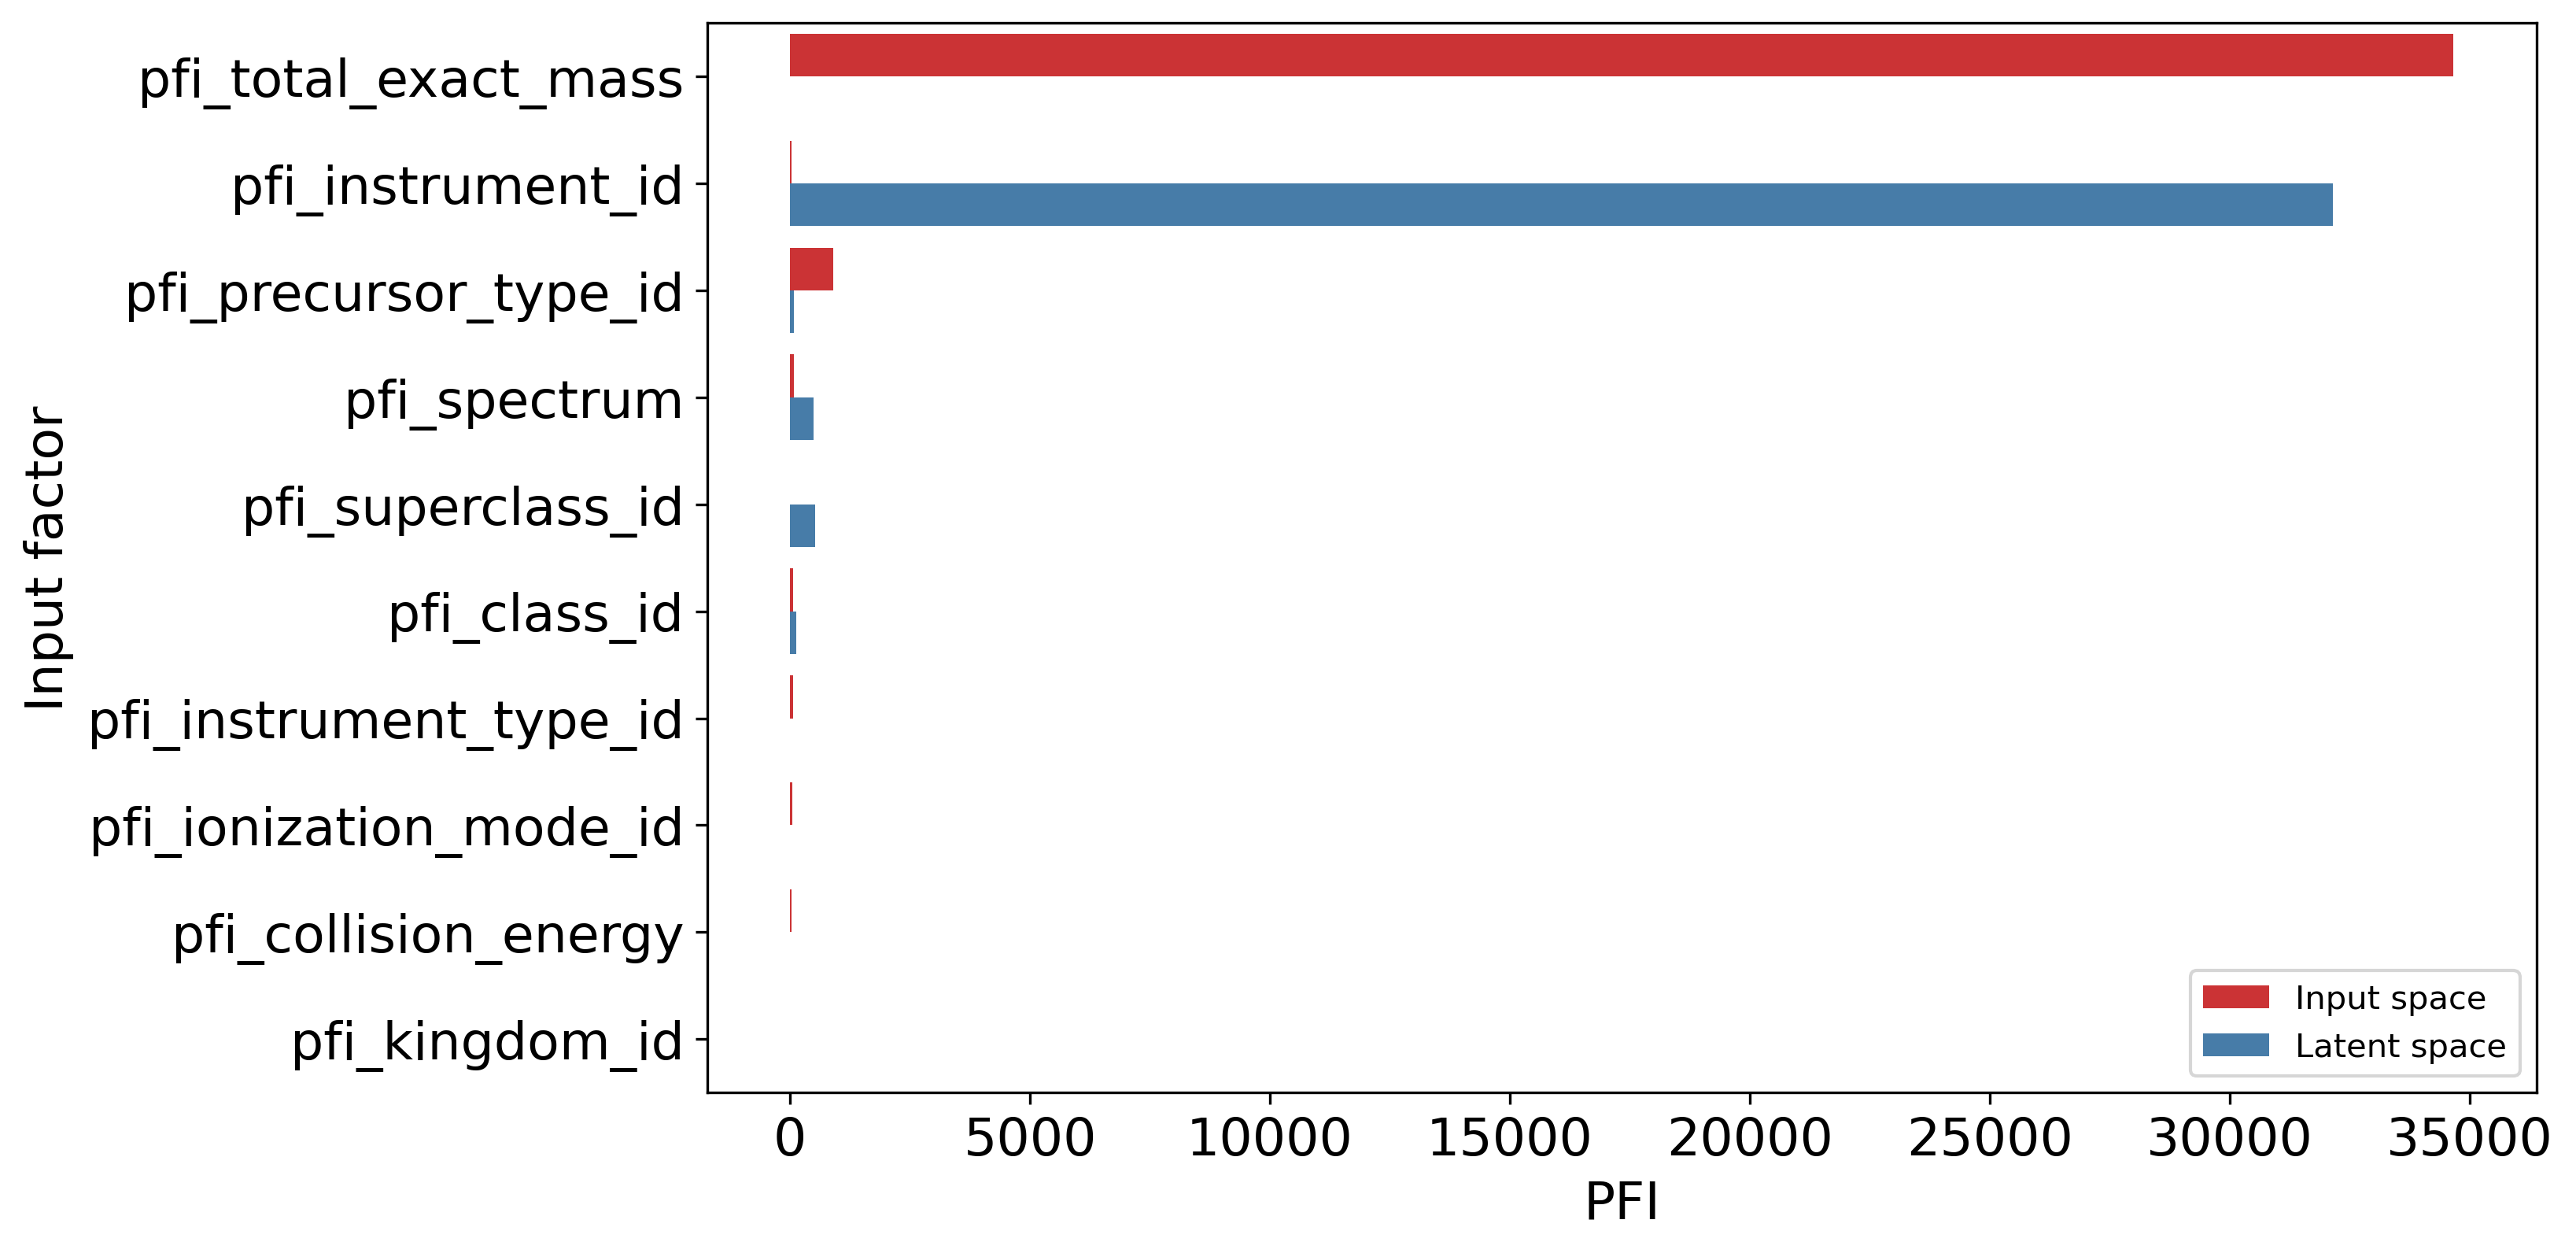

total_exact_mass


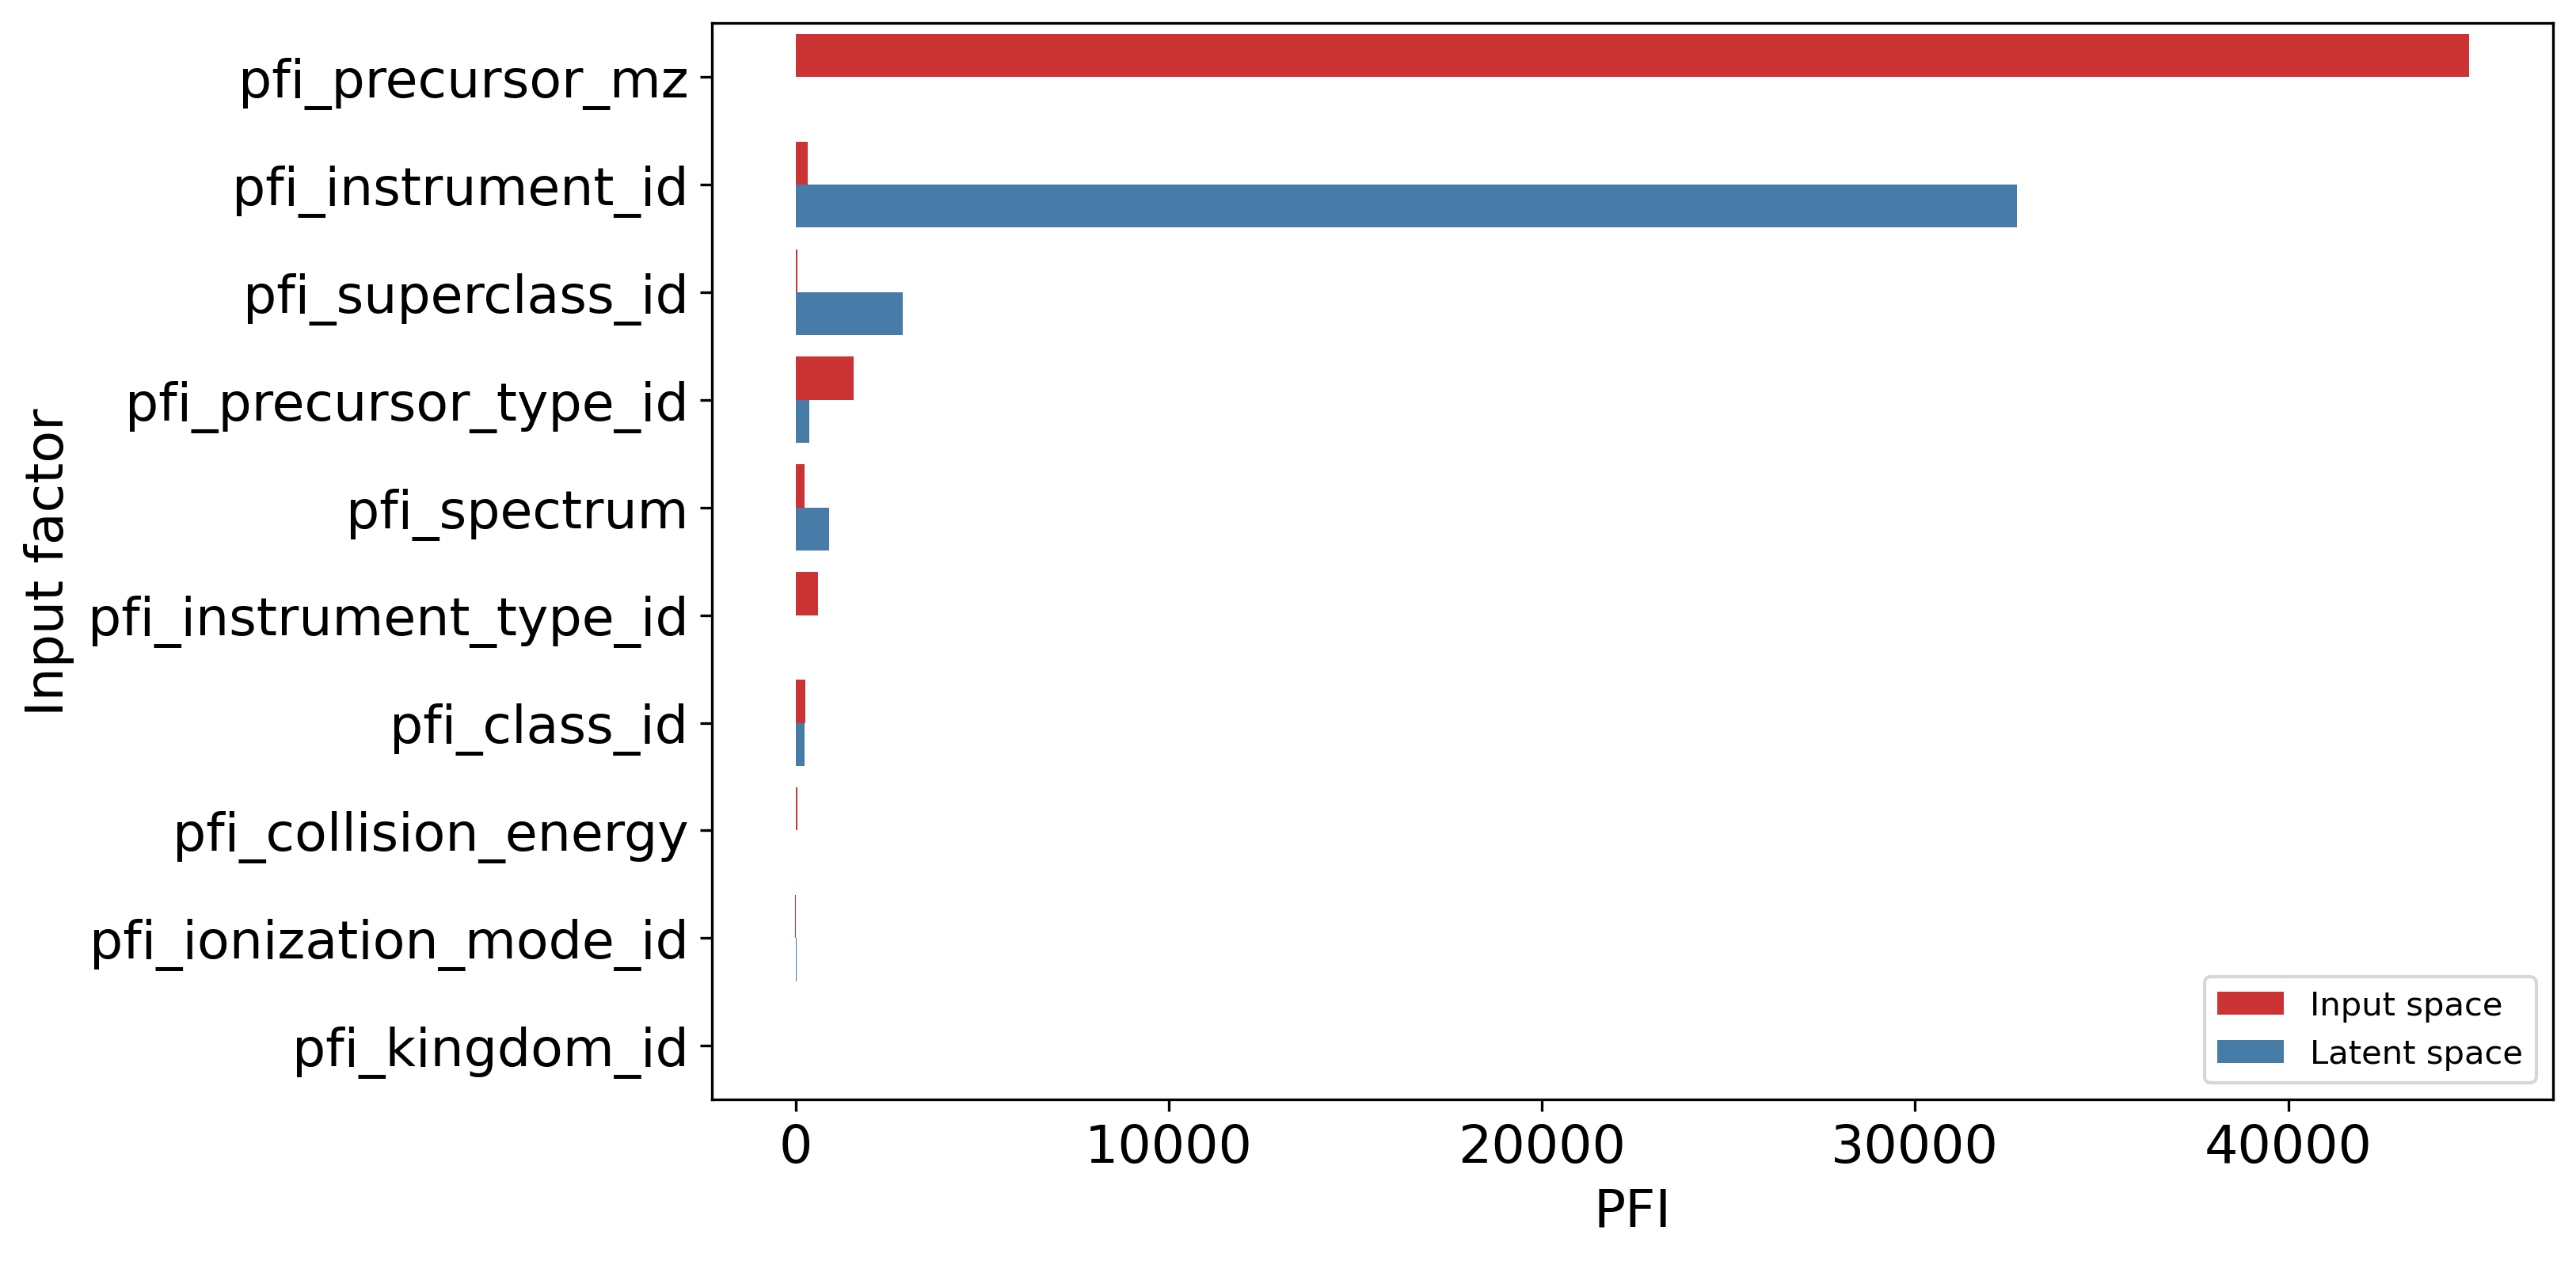

In [86]:
for tc in target_columns:
    print(tc)
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
    plot_pfi(df[df['dataset'] == 'MoNA'], tc, hue='Type')
    plt.legend(loc='lower right')
    plt.ylabel('Input factor', font={'size': 16})
    plt.xlabel('PFI', font={'size': 16})
    plt.yticks(font={'size': 16})
    plt.xticks(font={'size': 16})
    plt.savefig('../.img/pfi-%s.svg' % tc)
    plt.show()


## Heatmap

In [87]:
def get_pfi_matrix(df, dataset):
    import ast
    pfi = df[df['dataset'] == dataset][['target_column', 'feature_importance']].copy().set_index('target_column', drop=False)
    scores = pfi.to_dict()['feature_importance']
    scores = {key: {k.replace('_id', ''): v for k, v in ast.literal_eval(val).items()} for key, val in scores.items()}
    cols = ['ionization_mode', 'instrument', 'instrument_type', 'precursor_type', 
            'kingdom', 'superclass', 'class', 'collision_energy', 'precursor_mz', 
            'total_exact_mass', 'spectrum']
    df_ = pd.DataFrame(data=scores).transpose()[cols]
    return df_

def normalize_pfi_matrix(df):
    df_ = df.fillna(0.).div(df.sum(axis=1), axis=0).fillna(0.)
    np.fill_diagonal(df_.values, 1.0)
    return df_

In [88]:
df_ = get_pfi_matrix(df1, 'MoNA')
df_

,ionization_mode,instrument,instrument_type,precursor_type,kingdom,superclass,class,collision_energy,precursor_mz,total_exact_mass,spectrum
ionization_mode,NaN,0.005879,0.000570,0.426225,0.0,-0.000350,-0.000760,0.000280,0.086953,0.108168,-0.019076
instrument,0.004089,NaN,0.375845,0.035513,0.0,0.014497,0.031924,0.171636,0.075335,0.038622,0.010668
instrument_type,0.000000,0.751610,NaN,0.000040,0.0,0.000000,0.000000,0.039502,0.120806,0.028894,0.000000
precursor_type,0.251220,0.103119,0.088382,NaN,0.0,-0.003179,-0.010748,-0.001910,0.465037,0.372486,0.026355
kingdom,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
superclass,-0.000720,-0.000040,0.001390,-0.003039,0.0,NaN,1.260588,-0.000910,0.013357,0.022326,-0.000560
class,0.012234,0.035389,0.013381,0.026454,0.0,0.590982,NaN,0.011060,0.060710,0.053188,-0.028929
collision_energy,0.532535,163.622916,97.016617,8.294867,0.0,12.673111,32.362943,NaN,127.802548,74.296567,457.357056
precursor_mz,37.900542,29.126097,63.557512,904.417390,0.0,2.860381,67.841573,20.432796,NaN,34660.737213,73.419942
total_exact_mass,-12.587659,322.577942,592.045544,1550.323901,0.0,50.082996,256.339661,51.811719,44847.573560,NaN,226.333508


In [89]:
df_ = normalize_pfi_matrix(df_)
dfnp = df_.to_numpy()
dfnp.shape

(10, 11)

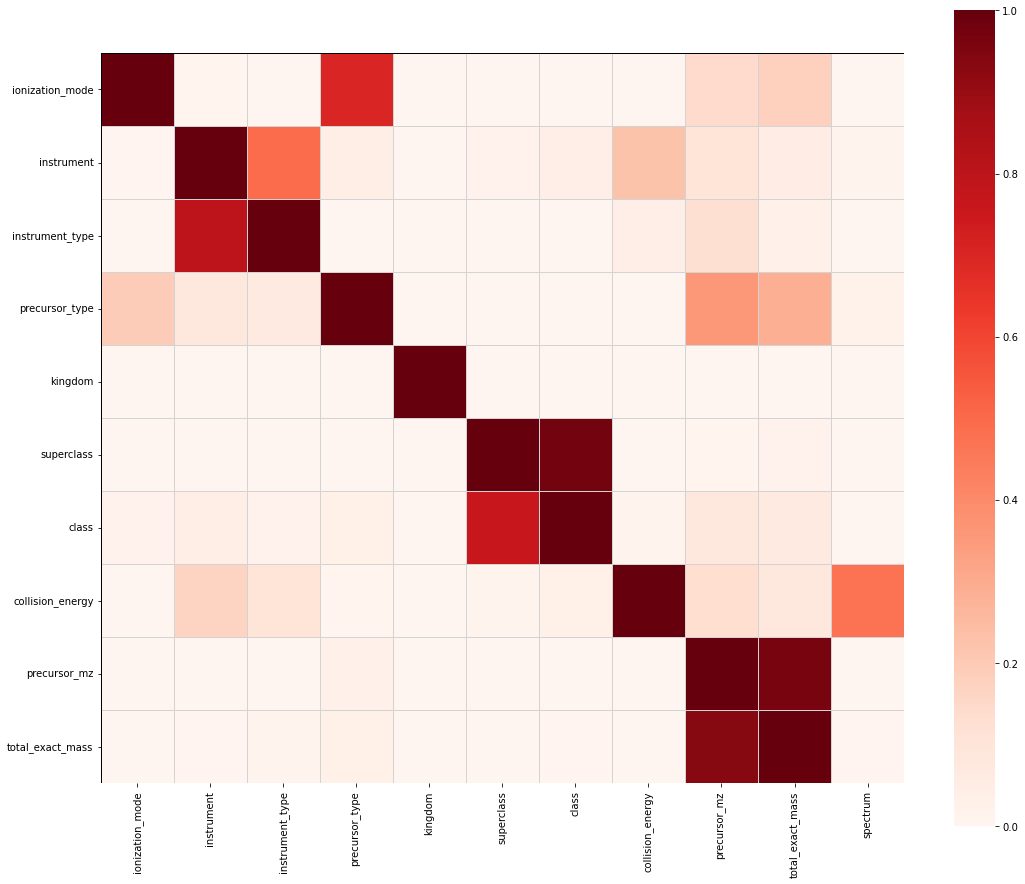

In [90]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(18, 15))
# sns.heatmap(df_, annot=True, annot_kws={"size": 14})
dfnp = df_.to_numpy()
ax = sns.heatmap(df_, square=True, linewidths=1., linecolor='lightgrey', vmin=0, vmax=1, cmap='Reds', ax=ax)
# plt.yticks(rotation=0, font={'size': 20})
# plt.xticks(rotation=90, font={'size': 20})
# plt.savefig('../.img/pfi-betavae-heatmap-mona.svg')
ax.axhline(y=0, color='k', linewidth=1)
ax.axhline(y=10, color='k', linewidth=1)
ax.axvline(x=0, color='k', linewidth=1)
ax.axvline(x=dfnp.shape[0] + 1, color='k', linewidth=1)

plt.savefig('../.img/pfi-heatmap-mona.svg')
plt.show()

In [91]:
df_ = get_pfi_matrix(df2, 'MoNA')
df_

,ionization_mode,instrument,instrument_type,precursor_type,kingdom,superclass,class,collision_energy,precursor_mz,total_exact_mass,spectrum
ionization_mode,NaN,0.068446,0.000020,0.000430,0.0,0.435683,0.026265,-0.000470,-0.000310,-0.000010,-0.003199
instrument,-0.003879,NaN,-0.036613,0.625155,0.0,0.105859,0.050230,-0.000240,-0.000310,0.000740,0.052050
instrument_type,0.000000,0.701560,NaN,0.003819,0.0,0.024265,-0.000130,0.000000,0.000000,0.000000,0.000010
precursor_type,0.000350,1.492721,0.000020,NaN,0.0,-0.000090,0.103419,-0.001140,-0.000180,-0.000110,0.034613
kingdom,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
superclass,0.000190,0.067167,0.000000,0.002260,0.0,NaN,0.927285,0.000080,0.002180,0.001250,0.016007
class,0.010389,0.067995,-0.000266,0.016499,0.0,0.002559,NaN,-0.001063,-0.002545,0.007061,0.058263
collision_energy,4.406372,284.046906,0.423132,120.959410,0.0,-3.043799,26.497122,NaN,15.708896,1.479037,805.393565
precursor_mz,0.529408,32157.953702,0.378766,81.844023,0.0,527.343983,127.649118,0.012569,NaN,-0.419604,482.527480
total_exact_mass,18.489197,32725.399385,0.557394,362.019083,0.0,2873.593057,239.006796,4.700540,8.536574,NaN,900.844037


In [92]:
df_ = normalize_pfi_matrix(df_)

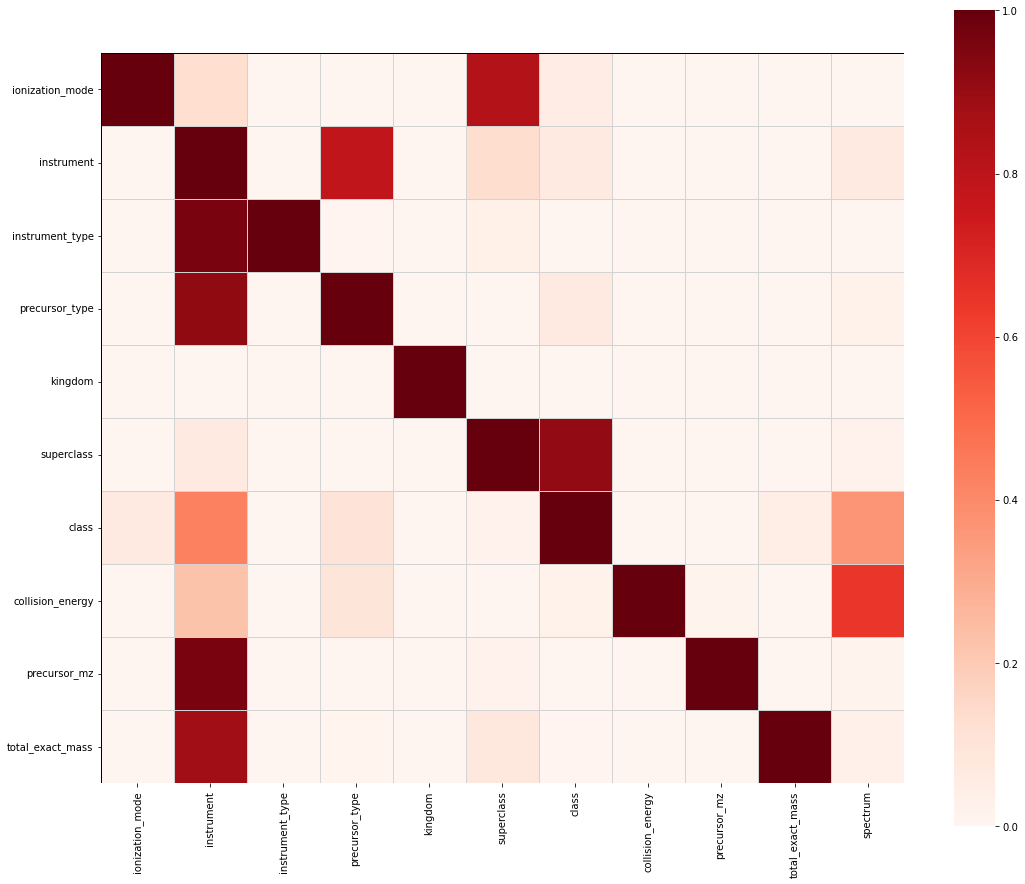

In [93]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(18, 15))
dfnp = df_.to_numpy()
ax = sns.heatmap(df_, square=True, linewidths=1., linecolor='lightgrey', vmin=0, vmax=1, cmap='Reds', ax=ax)
# plt.yticks(rotation=0, font={'size': 20})
# plt.xticks(rotation=90, font={'size': 20})
# plt.savefig('../.img/pfi-betavae-heatmap-mona.svg')
ax.axhline(y=0, color='k', linewidth=1)
ax.axhline(y=10, color='k', linewidth=1)
ax.axvline(x=0, color='k', linewidth=1)
ax.axvline(x=dfnp.shape[0] + 1, color='k', linewidth=1)
# sns.heatmap(df_, annot=True, annot_kws={"size": 14})
# plt.yticks(rotation=0, font={'size': 20})
# plt.xticks(rotation=90, font={'size': 20})
plt.savefig('../.img/pfi-betavae-heatmap-mona.svg')